# IL2233 Lab 2 - ARIMA Model and Prediction

## Imports

In [80]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from random import gauss, seed, randint
from pandas import Series, plotting, read_csv
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller, acovf
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

**Helper functions**

In [69]:
# Line plot, histogram, density plot, box plot, lag-1 plot, ACF and PACF graphs
def plot_all(series: Series, lags: int, title: str = ""):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))
    fig.subplots_adjust()
    fig.suptitle(title, fontsize=24)

    series.plot(ax=axes[0,0], kind='line', title='Line plot', xlabel='SV #', ylabel='Value')
    series.plot(ax=axes[0,1], kind='hist', title='Histogram', xlabel='Value', ylabel='frequency')
    series.plot(ax=axes[1,0], kind='box', title='Box plot')
    series.plot(ax=axes[1,1], kind='density', title='Density plot', xlabel='', ylabel='density')
    plotting.lag_plot(series, ax=axes[2,0], lag=1)
    plotting.lag_plot(series, ax=axes[2,1], lag=2)
    plot_acf(series, ax=axes[3,0])
    plot_pacf(series, lags=lags, ax=axes[3,1], method='ywm');

def ljungbox(series: Series):
    return sm.stats.acorr_ljungbox(series)

def adfuller_test(series: Series):
    result = adfuller(series, autolag='AIC')
    adfstat = result[0]
    pvalue = result[1]
    print(f'ADF Statistic: {adfstat}')
    print(f'p-value: {pvalue}')

    critvals_lt_adfstat = 0
    print('Critial Values:')
    for key, value in result[4].items():
        print(f'{key}, {value}')
        if (value < adfstat):
            critvals_lt_adfstat += 1
    print("-"*30)
    print(f"Critical values less than adf statistic: {critvals_lt_adfstat}")
    print(f"p-value is below the 5% significance level: {pvalue < 0.05}")
    print(f"Stationary? {critvals_lt_adfstat == 0 and pvalue < 0.05}")
    print("-"*30)


def gen_arma(lagcoeffs_ar: list[int] = [], lagcoeffs_ma: list[int] = [], nsample: int = 250):
    lagcoeffs_ar = np.r_[1, -np.array(lagcoeffs_ar)] if len(lagcoeffs_ar) > 0 else np.array([1])
    lagcoeffs_ma = np.r_[1, np.array(lagcoeffs_ma)] if len(lagcoeffs_ma) > 0 else np.array([1])

    proc = ArmaProcess(lagcoeffs_ar, lagcoeffs_ma)

    generated_time_series = proc.generate_sample(nsample)
    return generated_time_series, proc

# Task 1: Stationarity of AR models

<Axes: title={'center': '4)'}>

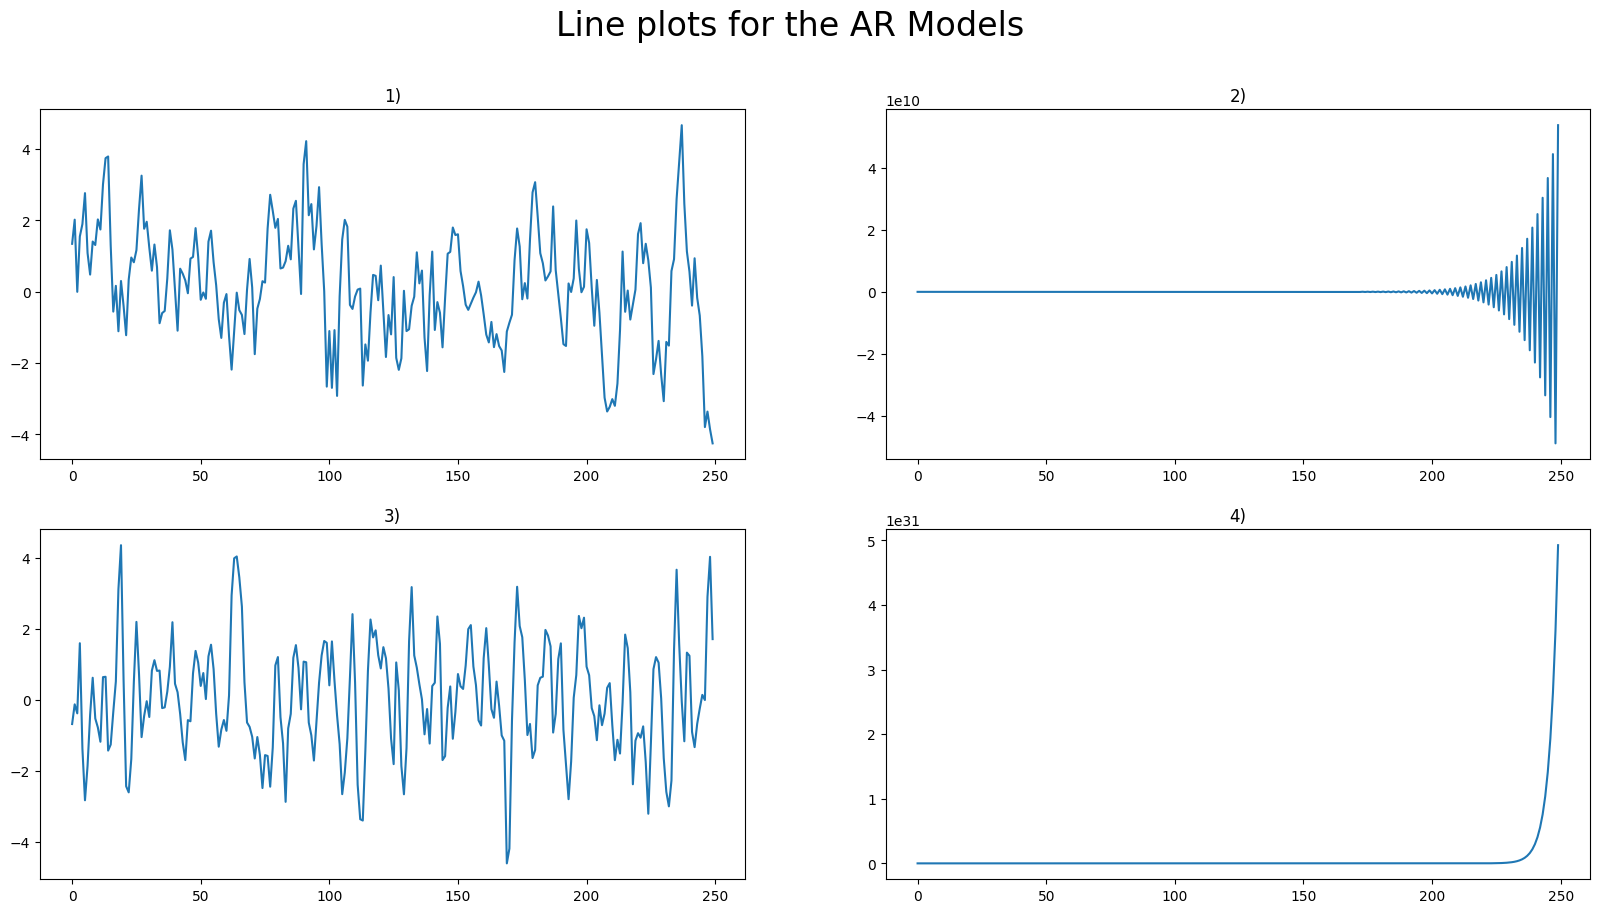

In [15]:
s1, p1 = gen_arma(lagcoeffs_ar=[0.8])
s2, p2 = gen_arma(lagcoeffs_ar=[-1.1])
s3, p3 = gen_arma(lagcoeffs_ar=[1, -0.5])
s4, p4 = gen_arma(lagcoeffs_ar=[1, 0.5])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.subplots_adjust()
fig.suptitle("Line plots for the AR Models", fontsize=24)
Series(s1).plot(ax=axes[0,0], kind='line', title='1)')
Series(s2).plot(ax=axes[0,1], kind='line', title='2)')
Series(s3).plot(ax=axes[1,0], kind='line', title='3)')
Series(s4).plot(ax=axes[1,1], kind='line', title='4)')

**Judging visually:**

None of the time series seem to be weakly stationary. In the case of 2), the mean may be constant but the variance is not.
We find that 3) could be potentially stationary, but further tests are required to determine this.

**Judging by coefficients:**

To determine if the generated time series are stationary we can check the following constraints on the coefficients:
- For p = 1: <u>−1 < $\phi_1$ < 1</u>.
- For p = 2: <u>−1 < $\phi_2$ < 1</u> AND <u>$\phi_2$ + $\phi_1$ < 1</u> AND <u>$\phi_2$ − $\phi_1$ < 1</u>.

- 1) AR(1) = $0.8x_{t-1} + \epsilon_t           \rightarrow -1 < \phi_1 = 0.8 < 1$, which **fulfills** the stationarity condition for $p = 1$
- 2) AR(1) = $-1.1x_{t-1} + \epsilon_t          \rightarrow -1 > \phi_1 = -1.1$, which does **not fulfill** the stationarity condition for $p = 1$
- 3) AR(2) = $1x_{t-1} - 0.5x_{t-2} \epsilon_t  \rightarrow -1 < \phi_2 = -0.5 < 1$, $\phi_2 + \phi_1 = 0.5 < 1$, and $\phi_2 - \phi_1 = 0.5 < 1$, which **fulfills** the stationarity condition for $p = 2$
- 4) AR(2) = $1x_{t-1} + 0.5x_{t-2} \epsilon_t  \rightarrow -1 < \phi_2 = 0.5 < 1$, $\phi_2 + \phi_1 = 1.5 > 1$, and $\phi_2 - \phi_1 = -0.5 < 1$, which does **not fulfill** the stationarity condition as the second criteria is not fulfilled

**Built-in function in statsmodels:**

From the output below, we validate that manual stationarity calculations were correct.

In [16]:
print(f"AR process 1 is stationary: {p1.isstationary}")
print(f"AR process 2 is stationary: {p2.isstationary}")
print(f"AR process 3 is stationary: {p3.isstationary}")
print(f"AR process 4 is stationary: {p4.isstationary}")

AR process 1 is stationary: True
AR process 2 is stationary: False
AR process 3 is stationary: True
AR process 4 is stationary: False


**Augmented Dickey-Fuller Test:**

One final stationarity test is done on the time series applying the ADF test. For each of the test outputs, we check if the ADF-statistic is less than all the critical values and also if the p-value is less than 0.5.

Our findings indicate the same results as previous tests.

In [17]:
adfuller_test(Series(s1))
print("-"*40)
adfuller_test(Series(s2))
print("-"*40)
adfuller_test(Series(s3))
print("-"*40)
adfuller_test(Series(s4))

ADF Statistic: -5.524926779108489
p-value: 1.8418834627703814e-06
Critial Values:
1%, -3.4568881317725864
5%, -2.8732185133016057
10%, -2.5729936189738876
------------------------------
Critical values less than adf statistic: 0
p-value is less than 5% margin: True
Stationary? True
------------------------------
----------------------------------------
ADF Statistic: -240583449491.08752
p-value: 0.0
Critial Values:
1%, -3.4568881317725864
5%, -2.8732185133016057
10%, -2.5729936189738876
------------------------------
Critical values less than adf statistic: 0
p-value is less than 5% margin: True
Stationary? True
------------------------------
----------------------------------------
ADF Statistic: -11.22518746969997
p-value: 1.9685721000248955e-20
Critial Values:
1%, -3.4569962781990573
5%, -2.8732659015936024
10%, -2.573018897632674
------------------------------
Critical values less than adf statistic: 0
p-value is less than 5% margin: True
Stationary? True
--------------------------

### Questions

- **With visual inspection, how do you identify if a time series is stationary or not?**
By visual inspection one can check what the mean seems to be for various intervals of the time series, but also for the time series as a whole. Variance is also easy to visually inspect over slices in time and for the whole series. Another easy inspection methods includes finding seasonality, i.e. repeating patterns.
'
- **How do you judge the stationarity of time series using the unit-root method? Does it always give correct results?**
We use the ADF test to judge stationarity. Based on the ADF statistic, negative values implies less probability of non stationarity.

- **What is the role of component $\epsilon_t$ in the model? Why is it important?**
$\epsilon_t$ is a Gaussian white noise with normal distribution (0, 1). There is always a measure of error to future values based on prediction from past data points, which need to be taken into consideration. The error $\epsilon_t$ does this.

- **To have an AR(p) model be stationary, is there any requirement on the auto-regressive coefficients? List the constraints for AR(1) and AR(2) models**
The following constraints are put on the coefficients to determine stationarity of the AR(p) model, where $\phi_t$ is the coefficient:

- For p = 1: <u>−1 < $\phi_1$ < 1</u>
- For p = 2: <u>−1 < $\phi_2$ < 1</u> AND <u>$\phi_2$ + $\phi_1$ < 1</u> AND <u>$\phi_2$ − $\phi_1$ < 1</u>

# Task 2: ACF, PACF of AR models

### Are all of them stationary? **Judging visually:**
At a first glance, 2) and 4) seem to be weakly stationary. 1) show signs of great variation of mean and variance at different intervals, and thus can't be considered weakly stationary. 3) could potentially be weakly stationary, but further tests are required to determine this.

### Are there any outliers? Why?
Looking at the box plot, we can see outliers in most cases. This, of course, depends on the gaussian white noise whether outliers exist or not. Our theory is that when the data points in a time series differ by a certain variance from the mean, this spawns outliers either above or below the box plot (depending on the data point being above or below the mean)

### Do you observe any auto-correlation from the lag plots?
The lag-1 plot seems to give a measure of autocorrelation, at least more than lag-2. Despite this, there is no clear autocorrelation for any of the given models.

### What characteristics can you observe from the ACF graphs of the AR(p) models?
Over time, the ACF graph converges to remain inside the confidence interval.

### What characteristics can you observe from the PACF graphs of the AR(p) models?
After the relevant lag = p + 1, the data points will be inside the confidence interval. This means that there is no considerable autocorrelation after the p + 1 lag, and we believe this is the case beceause the AR model does not use any further "lag" than that.

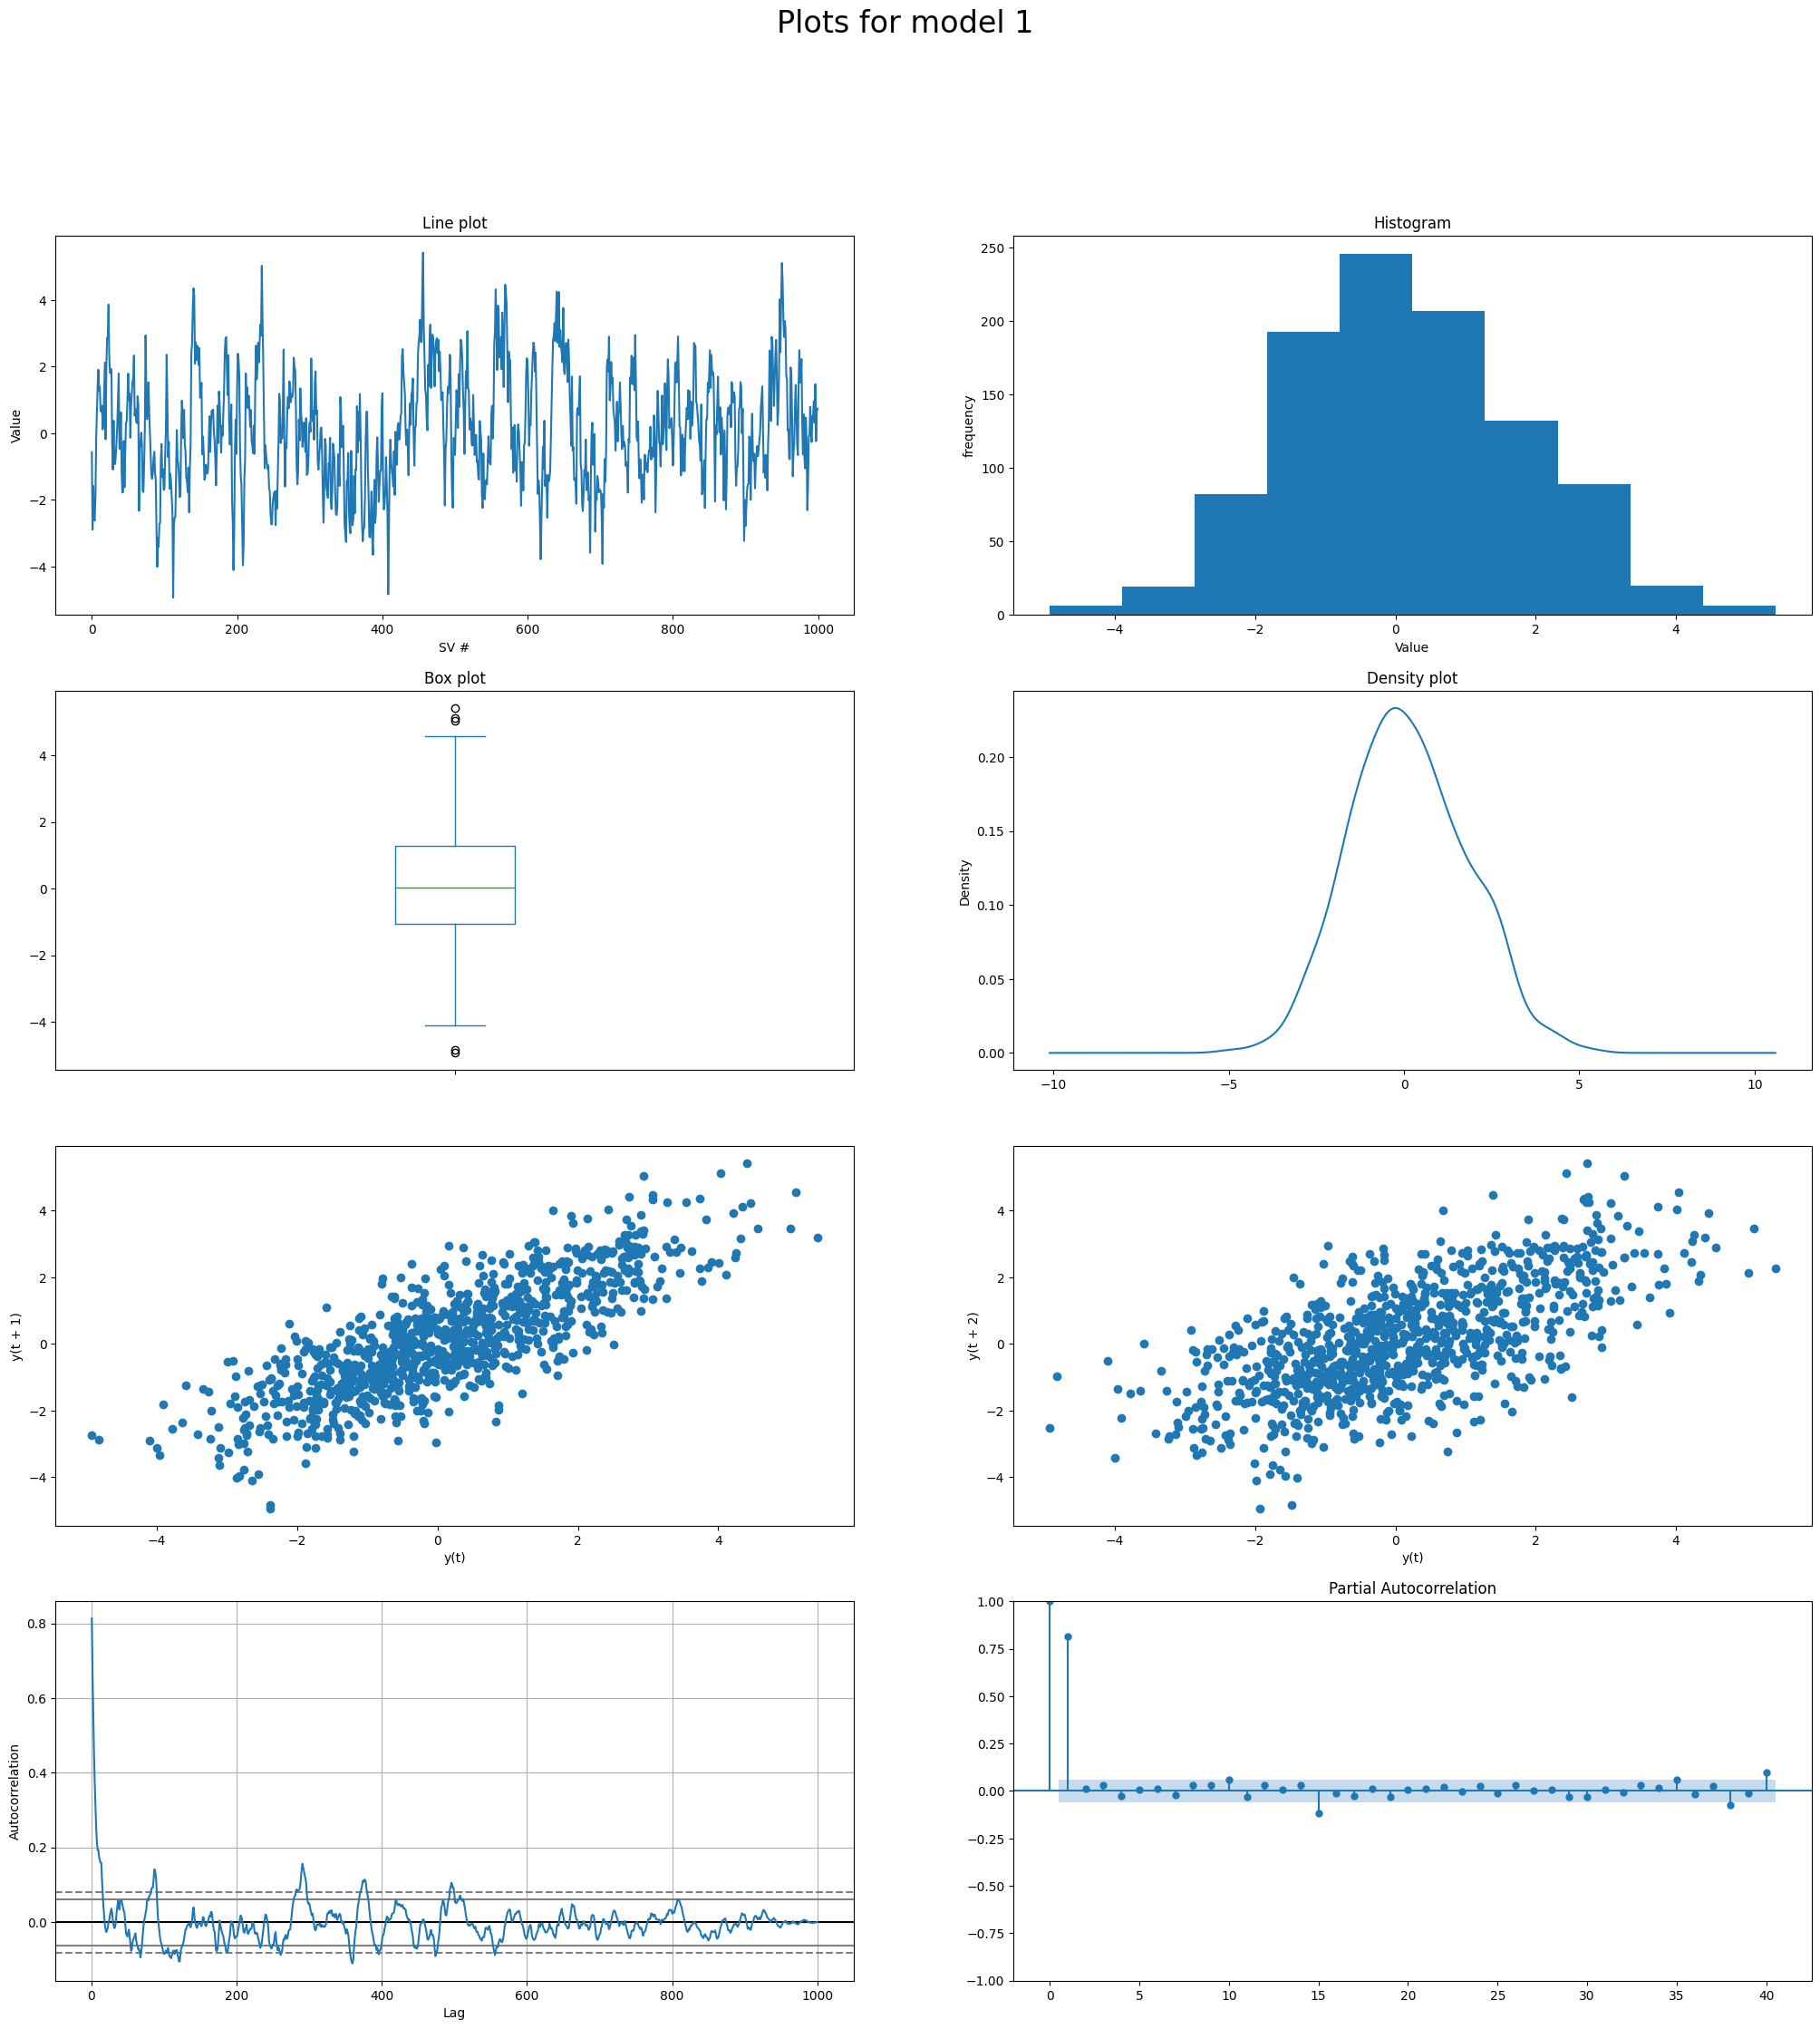

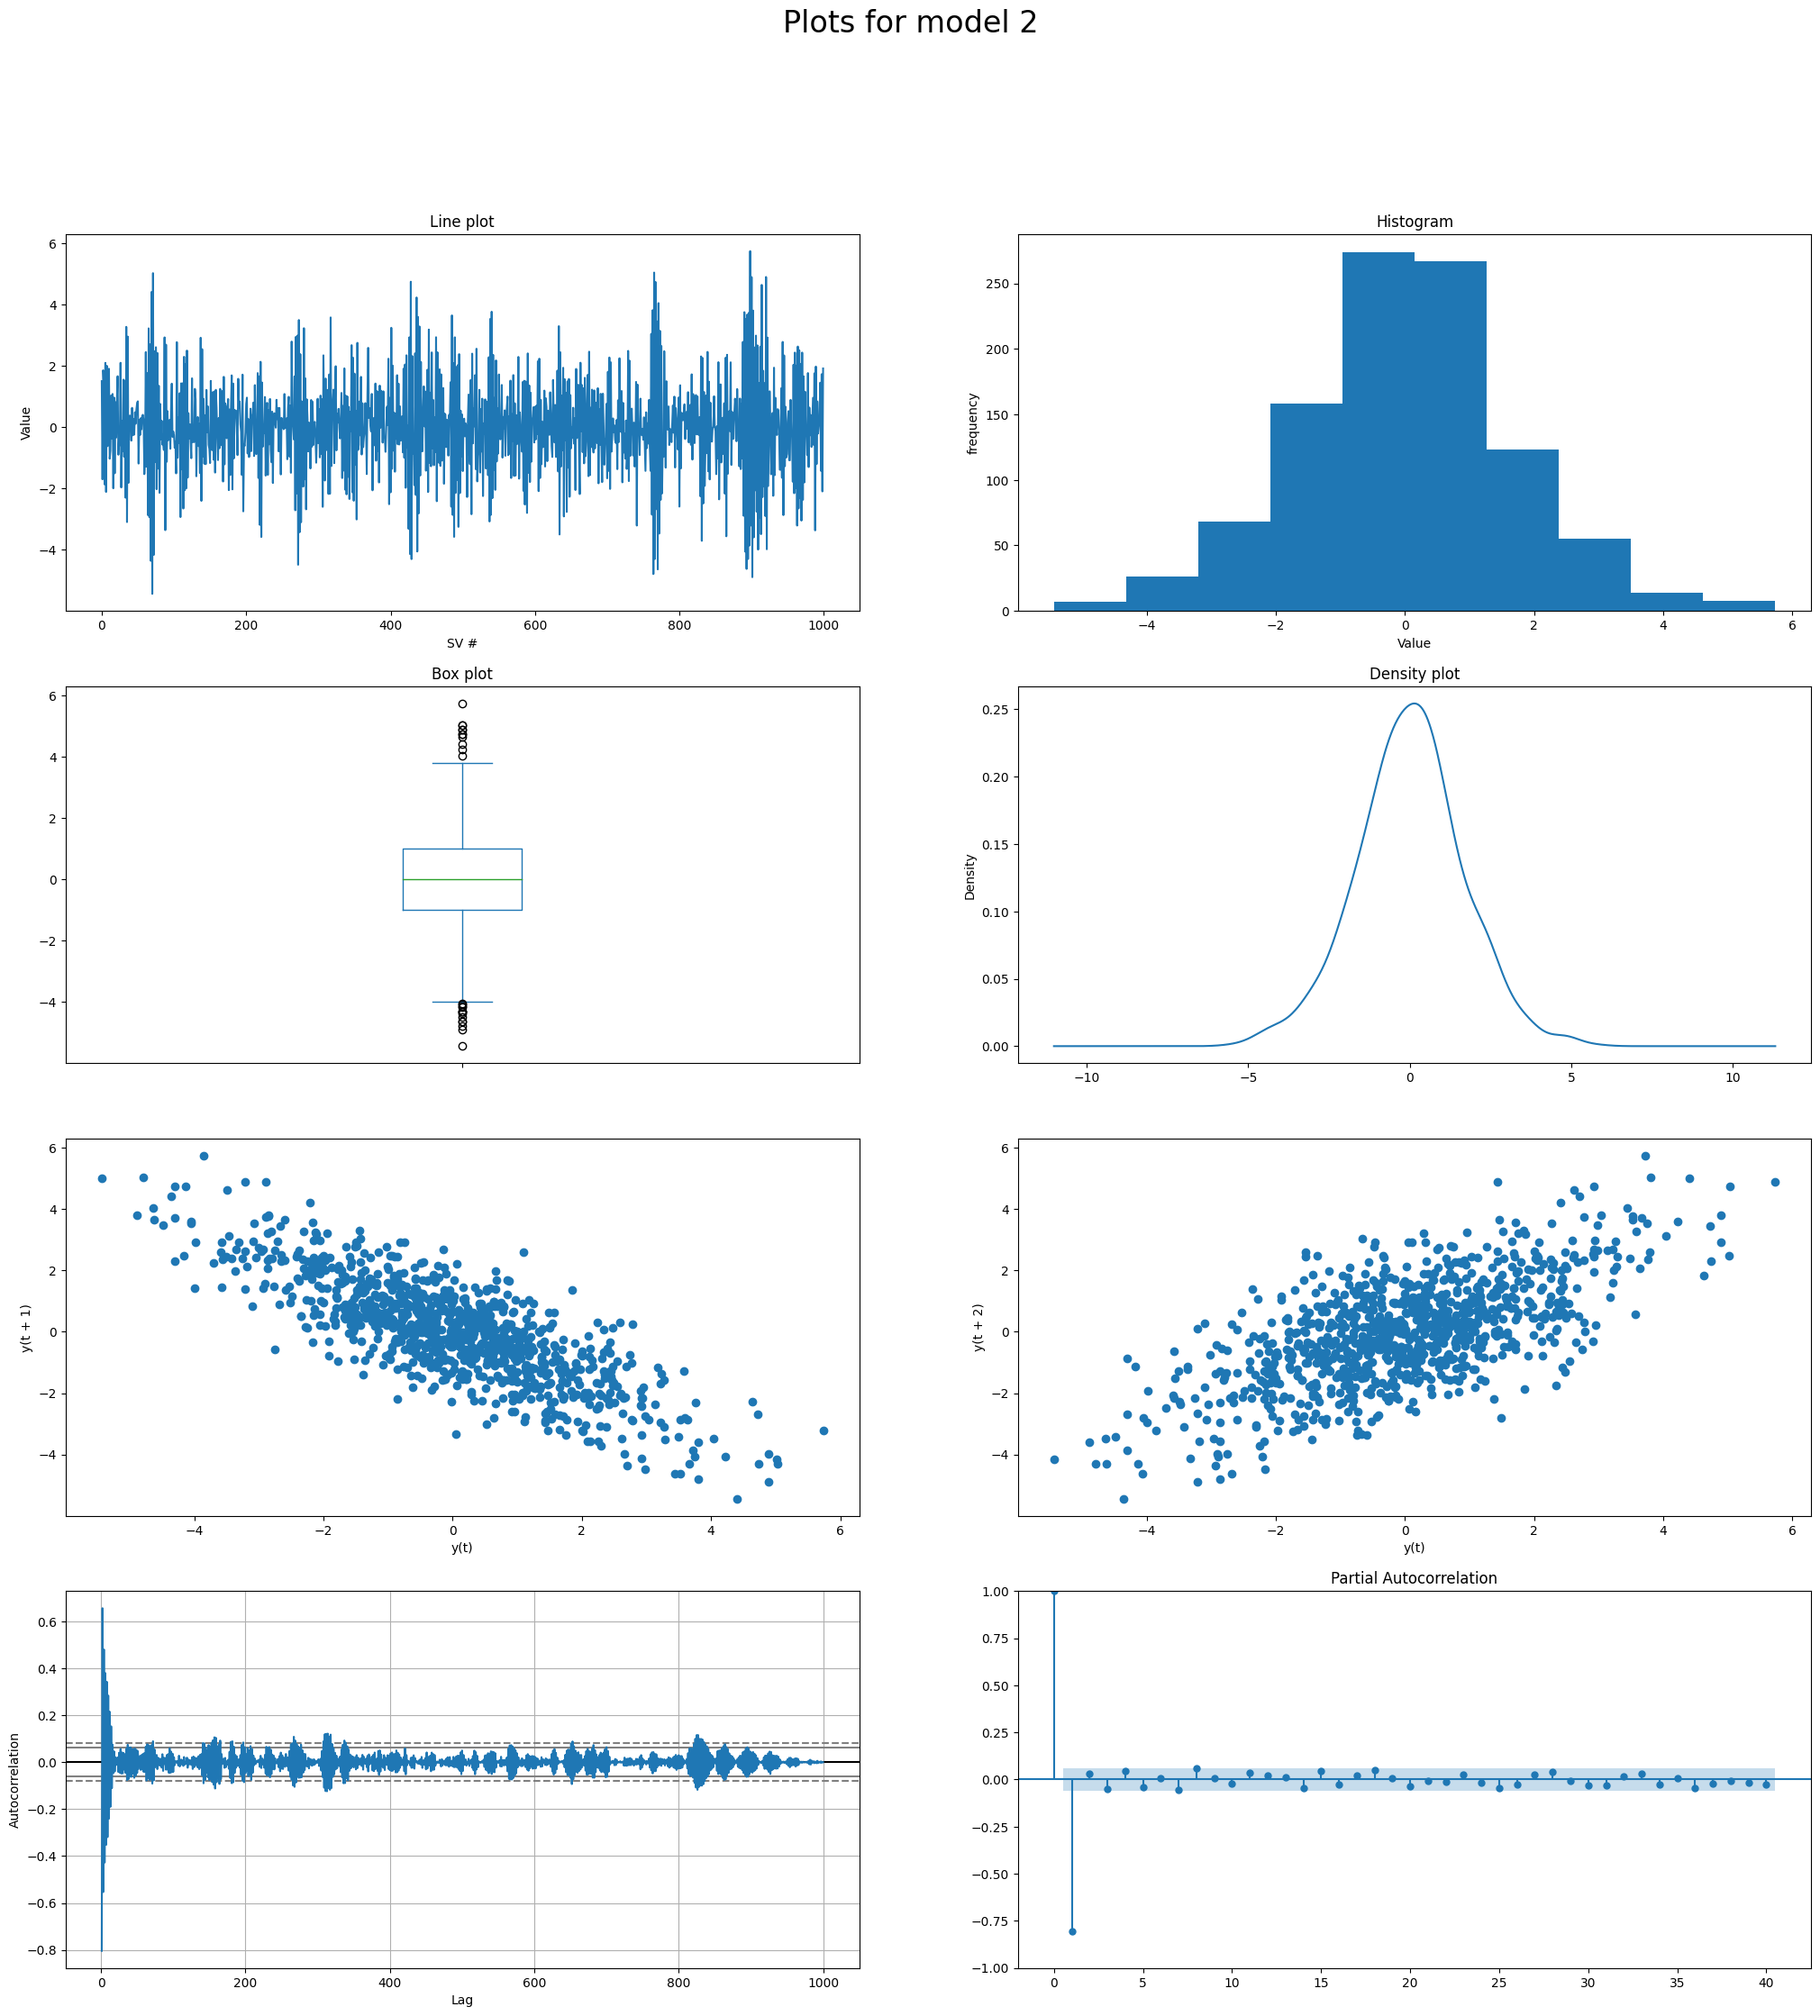

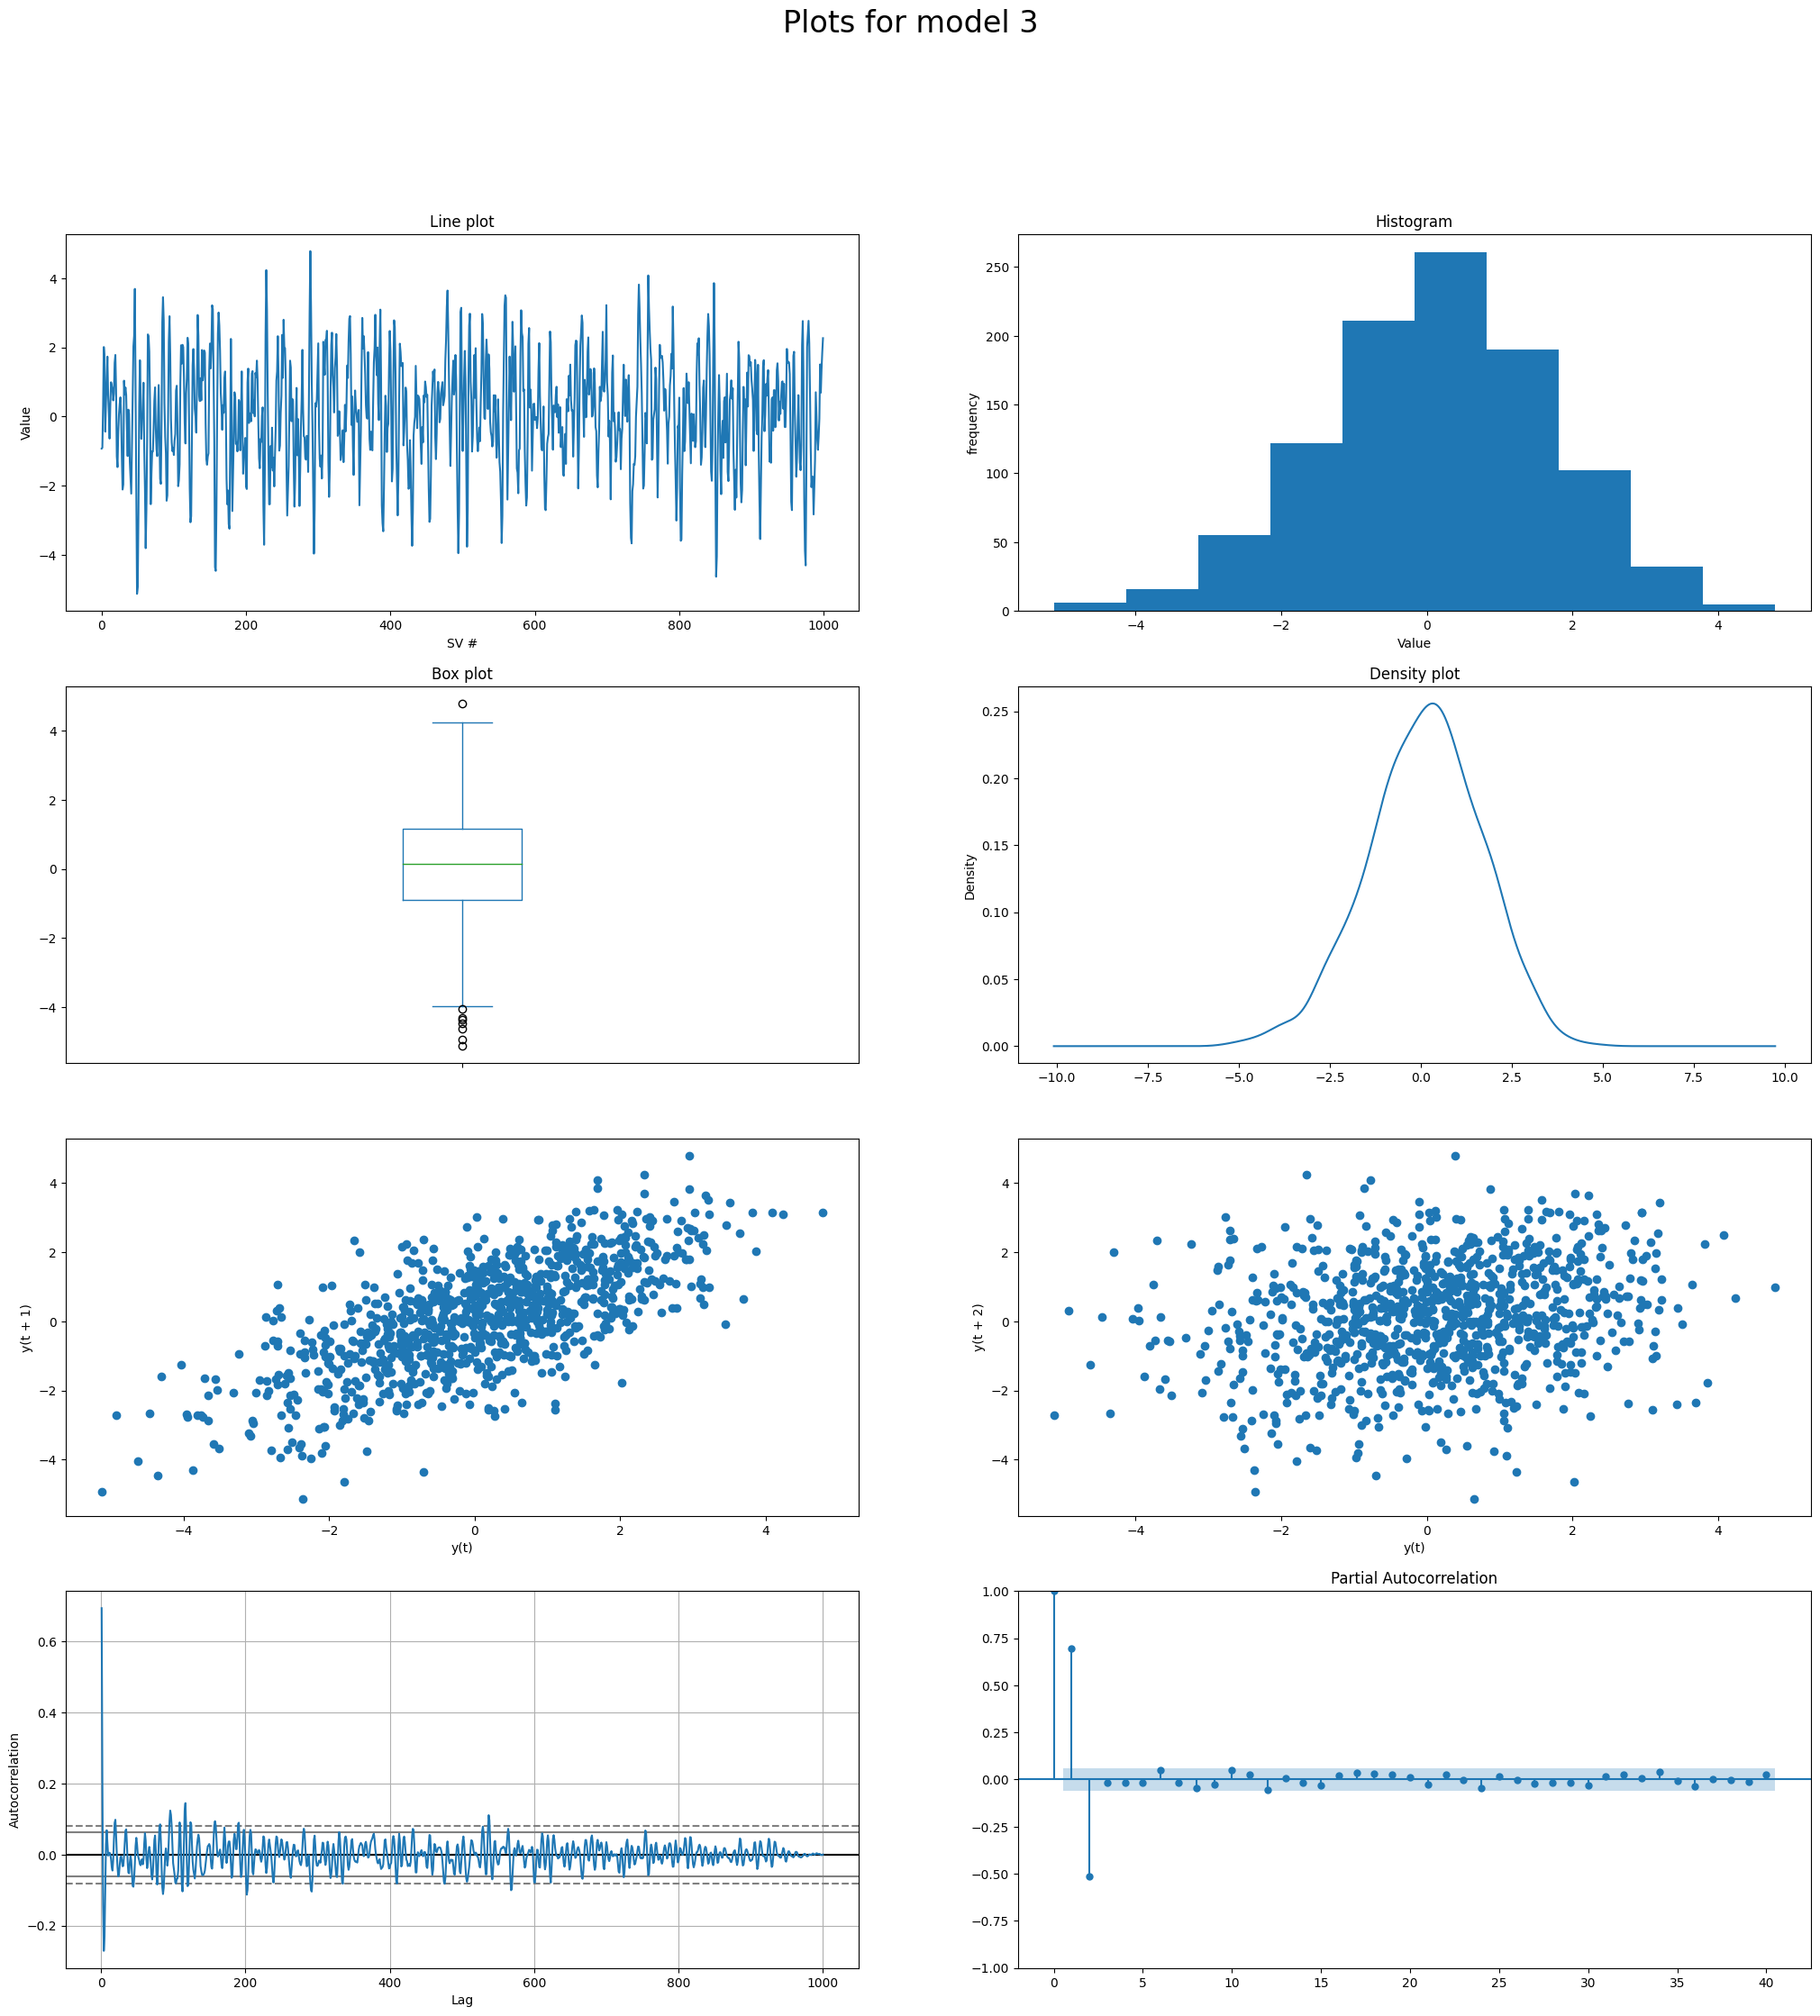

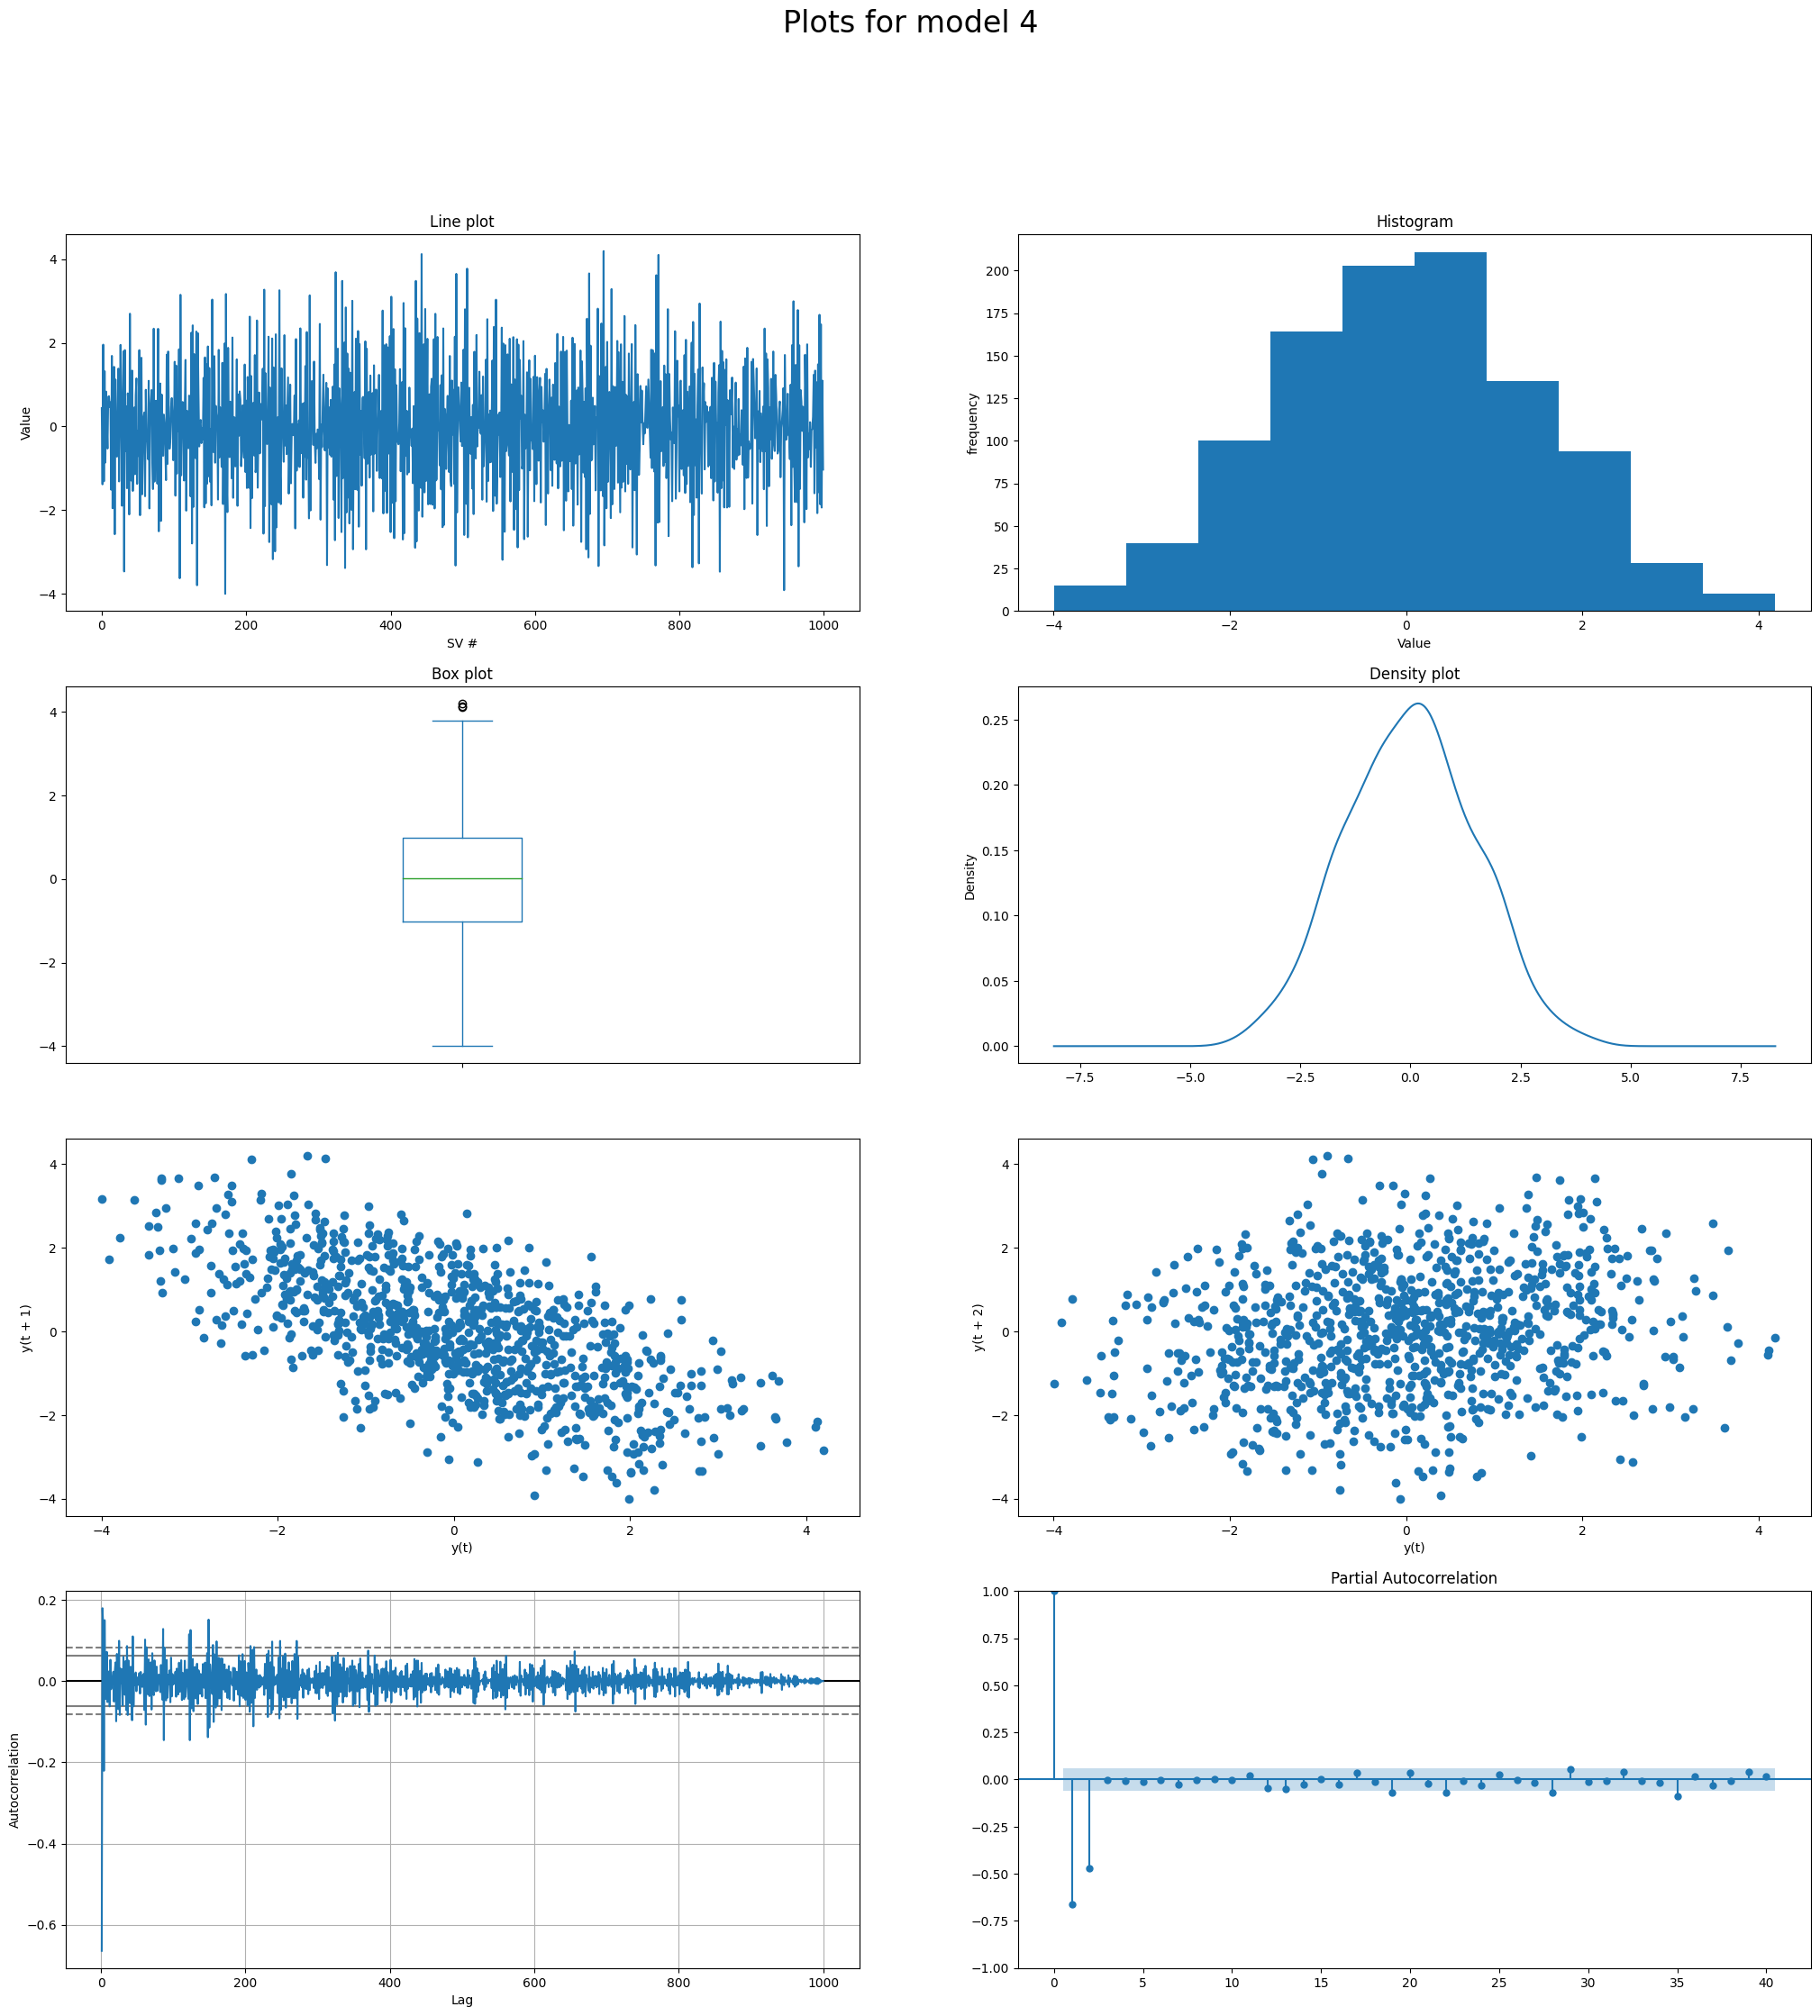

In [18]:
s1, p1 = gen_arma(lagcoeffs_ar=[0.8], nsample=1000)
s2, p2 = gen_arma(lagcoeffs_ar=[-0.8], nsample=1000)
s3, p3 = gen_arma(lagcoeffs_ar=[1, -0.5], nsample=1000)
s4, p4 = gen_arma(lagcoeffs_ar=[-1, -0.5], nsample=1000)

plot_all(Series(s1), lags=40, title="Plots for model 1");
plot_all(Series(s2), lags=40, title="Plots for model 2");
plot_all(Series(s3), lags=40, title="Plots for model 3");
plot_all(Series(s4), lags=40, title="Plots for model 4");

# Task 3: Invertibility, ACF, PACF of MA models

### Are all of them invertible, just by visual inspection?
It is uncertain whether invertibility can be determined through visual inspection. 

### Judge whether each time series is invertible or not, by its models’s auto-regressive coefficient values.
The following constraints are put on the coefficients to determine invertability of the MA(p) model, where $\theta_t$ is the coefficient:

- For q = 1: <u>−1 < $\theta_1$ < 1</u>
- For q = 2: <u>−1 < $\theta_2$ < 1</u> AND <u>$\theta_2$ + $\theta_1$ < 1</u> AND <u>$\theta_1$ − $\theta_2$ < 1</u>

- 1) MA(1) = $\epsilon_t - 2 \epsilon_{t-1} \rightarrow -1 < \theta_1 = 2 < 1$, which **not fulfill** the invertibility condition for $p = 1$.
- 2) MA(1) = $\epsilon_t - 0.5 \epsilon_{t-1} \rightarrow -1 > \theta_1 = 0.5$, which does **fulfill** the invertibility condition for $p = 1$.
- 3) MA(2) = $\epsilon_t - \frac{4}{5} \epsilon_{t-1} + \frac{16}{25} \epsilon_{t-2} \rightarrow -1 < \theta_2 = 16/25 < 1$, $\theta_2 + \theta_1 = -0.16 > -1$, and $\theta_1 - \theta_2 = 0.16 < 1$, which **fulfills** the invertibility condition for $p = 2$.
- 4) MA(2) = $\epsilon_t - \frac{5}{4} \epsilon_{t-1} + \frac{25}{16} \epsilon_{t-2} \rightarrow -1 < \theta_2 = 25/16$, but $> 1$ which does **not fulfill** the invertibility because of the first criterion for p = 2.

### Call the following statsmodel function to judge if each MA process is invertible
The function calls show us that processes 1 and 4 are **not** invertible, whereas processses 2 and 3 **are** invertible.

### Draw histogram, density plot, and box plot for each time series with 1000 data points. Are there any outliers? Why?
Outliers occur in most cases. They exist because the error distribution can sometimes generate values outside the standard confidence intervals simply and then they become outliers in the box plot.

### Draw lag-1 and lag-2 plots for each time series. Do you observe any auto-correlation from the lag plots?
There is no discernible auto-correlation in the lag plots.

## Questions

### Are all the MA models invertible? If not, which ones are invertible and which ones are not invertible?
The second (2nd) and third (3rd) are invertble, the remaining are not.

### What characteristics can you observe from the ACF graphs of the MA(q) models?
In regards to invertibility, since two different MA(q) models can generate the same ACF graph, not conclusion can be drawn.

### What characteristics can you observe from the PACF graphs of the MA(q) models?
In regards to invertibility, since two different MA(q) models can generate the same PACF graph, not conclusion can be drawn.


### To have an MA(q) model be invertible, is there any requirement on the auto-regressive coefficients? List the constraints for MA(1) and MA(2) models.
The following constraints are required on the MA(1) and MA(2) models for invertibility

- For q = 1: <u>−1 < $\theta_1$ < 1</u>
- For q = 2: <u>−1 < $\theta_2$ < 1</u> AND <u>$\theta_2$ + $\theta_1$ < 1</u> AND <u>$\theta_2$ − $\theta_1$ < 1</u>

Is process 1 invertible? False
Is process 2 invertible? True
Is process 3 invertible? True
Is process 4 invertible? False


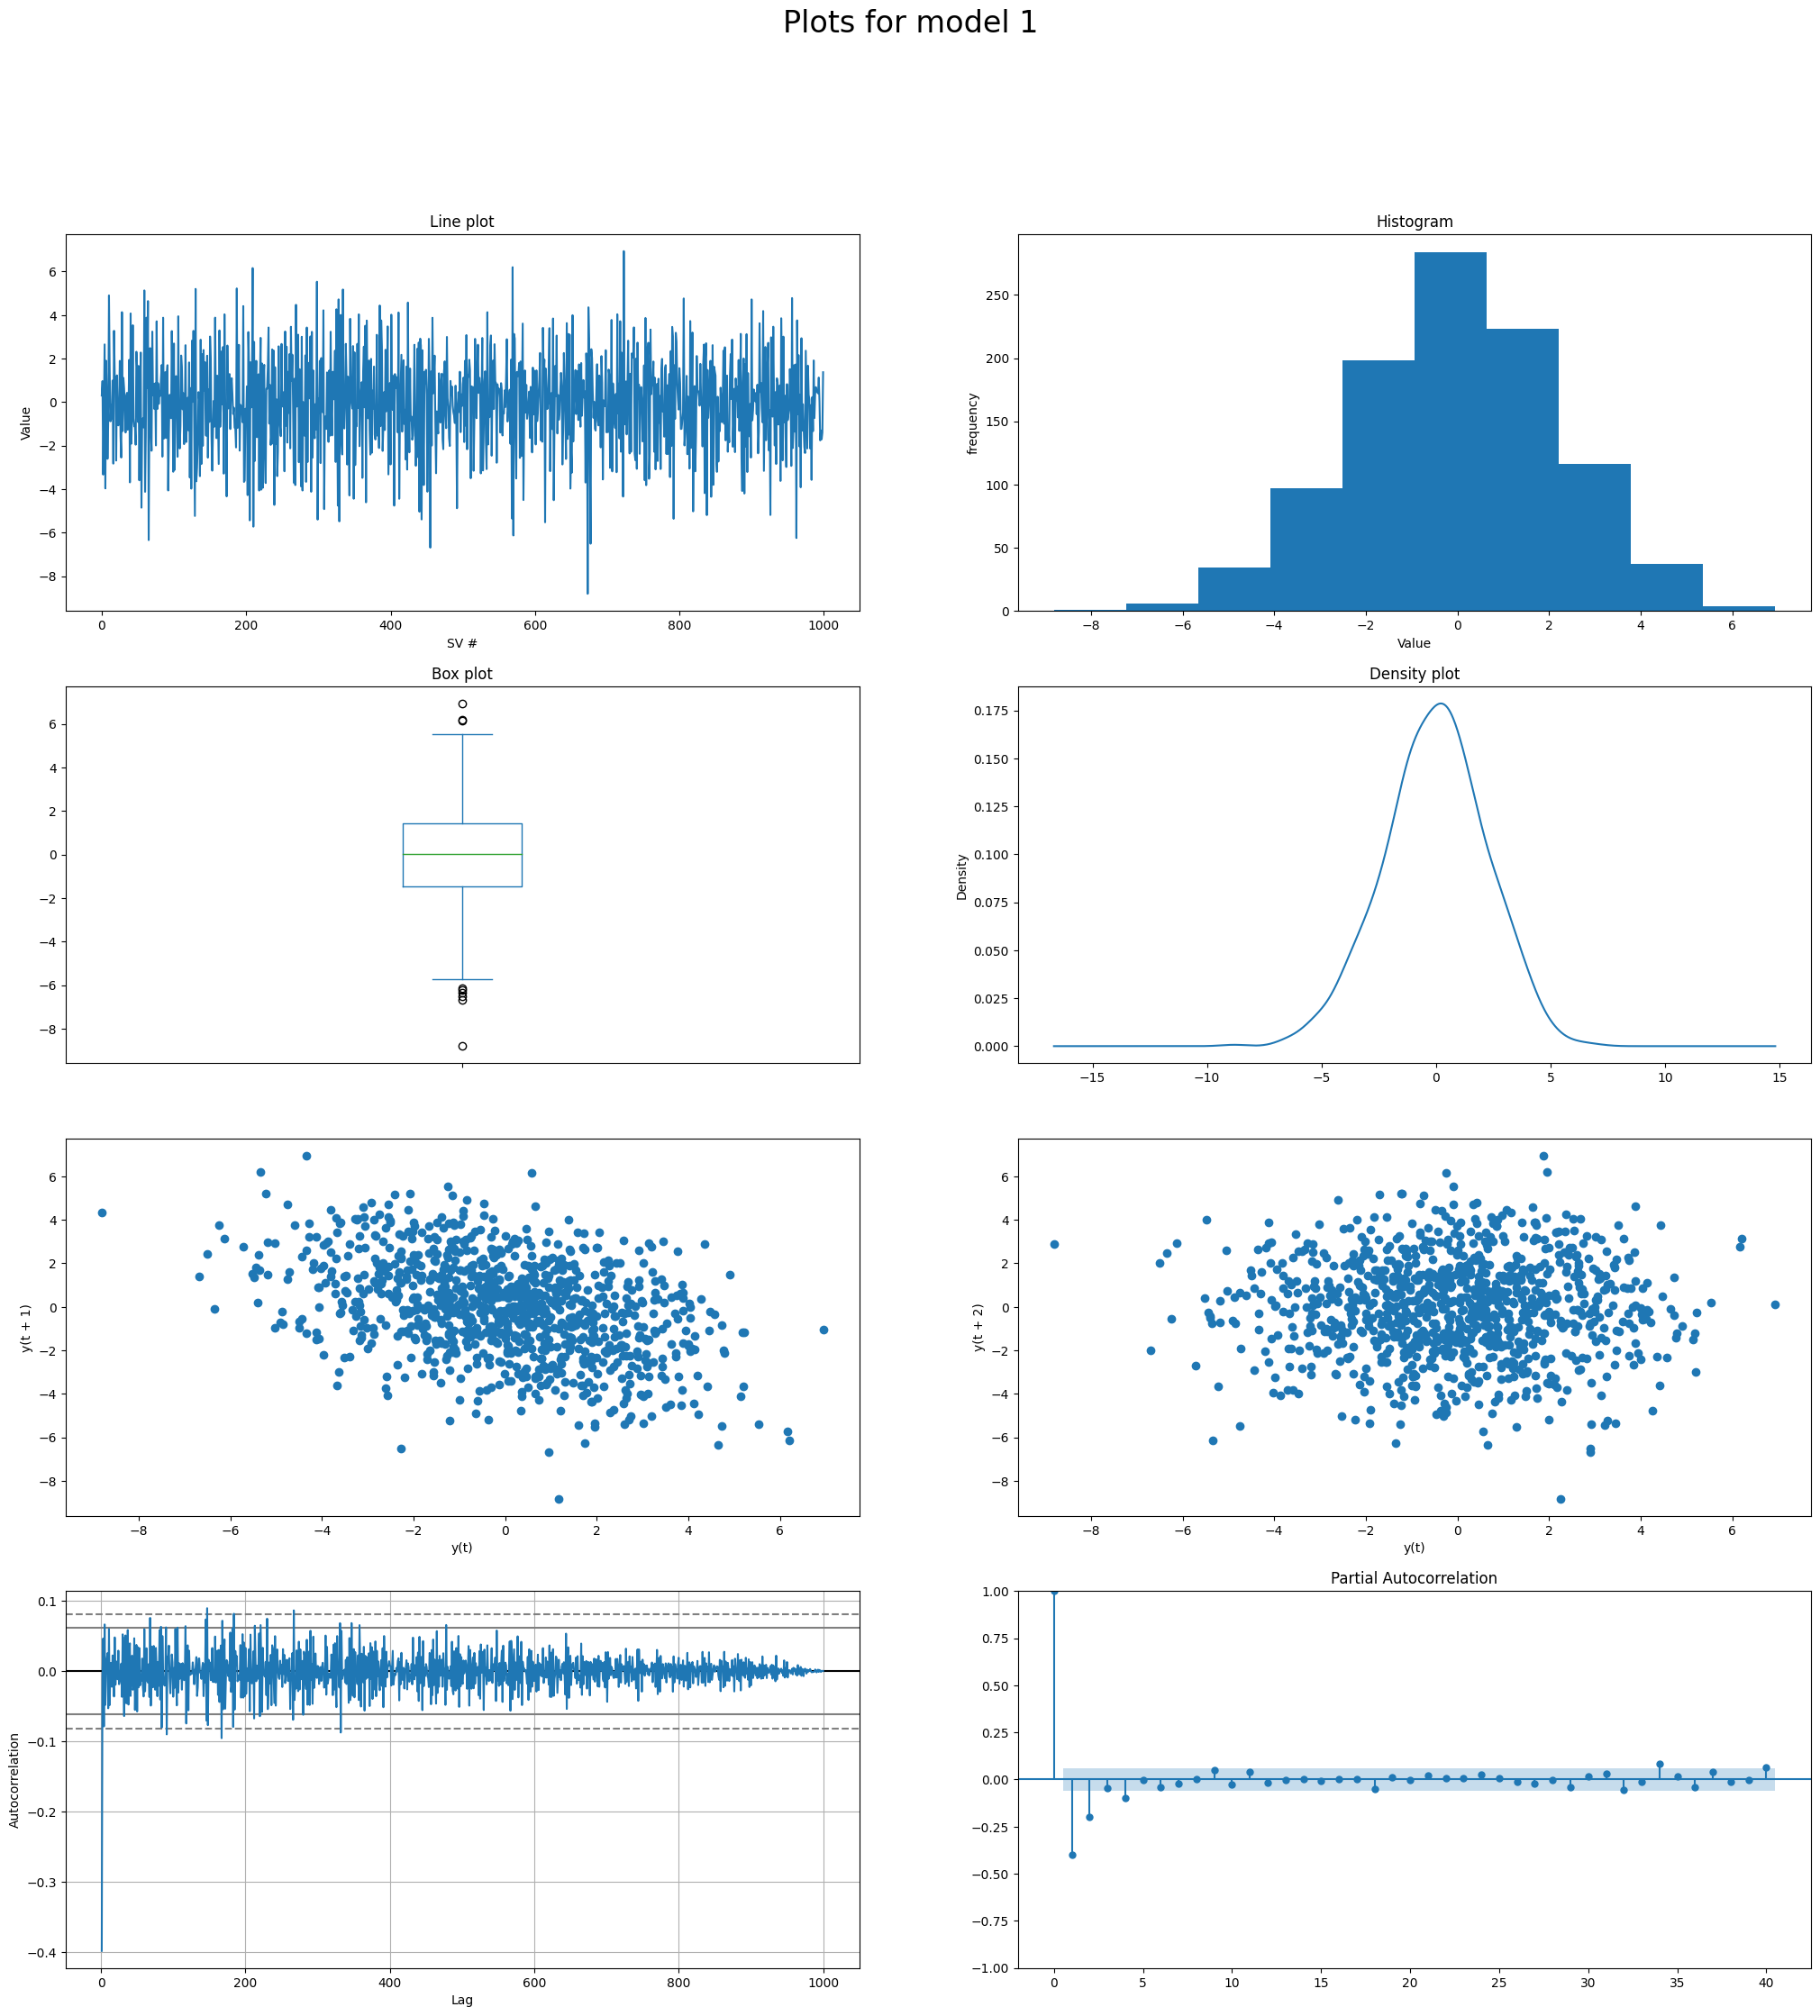

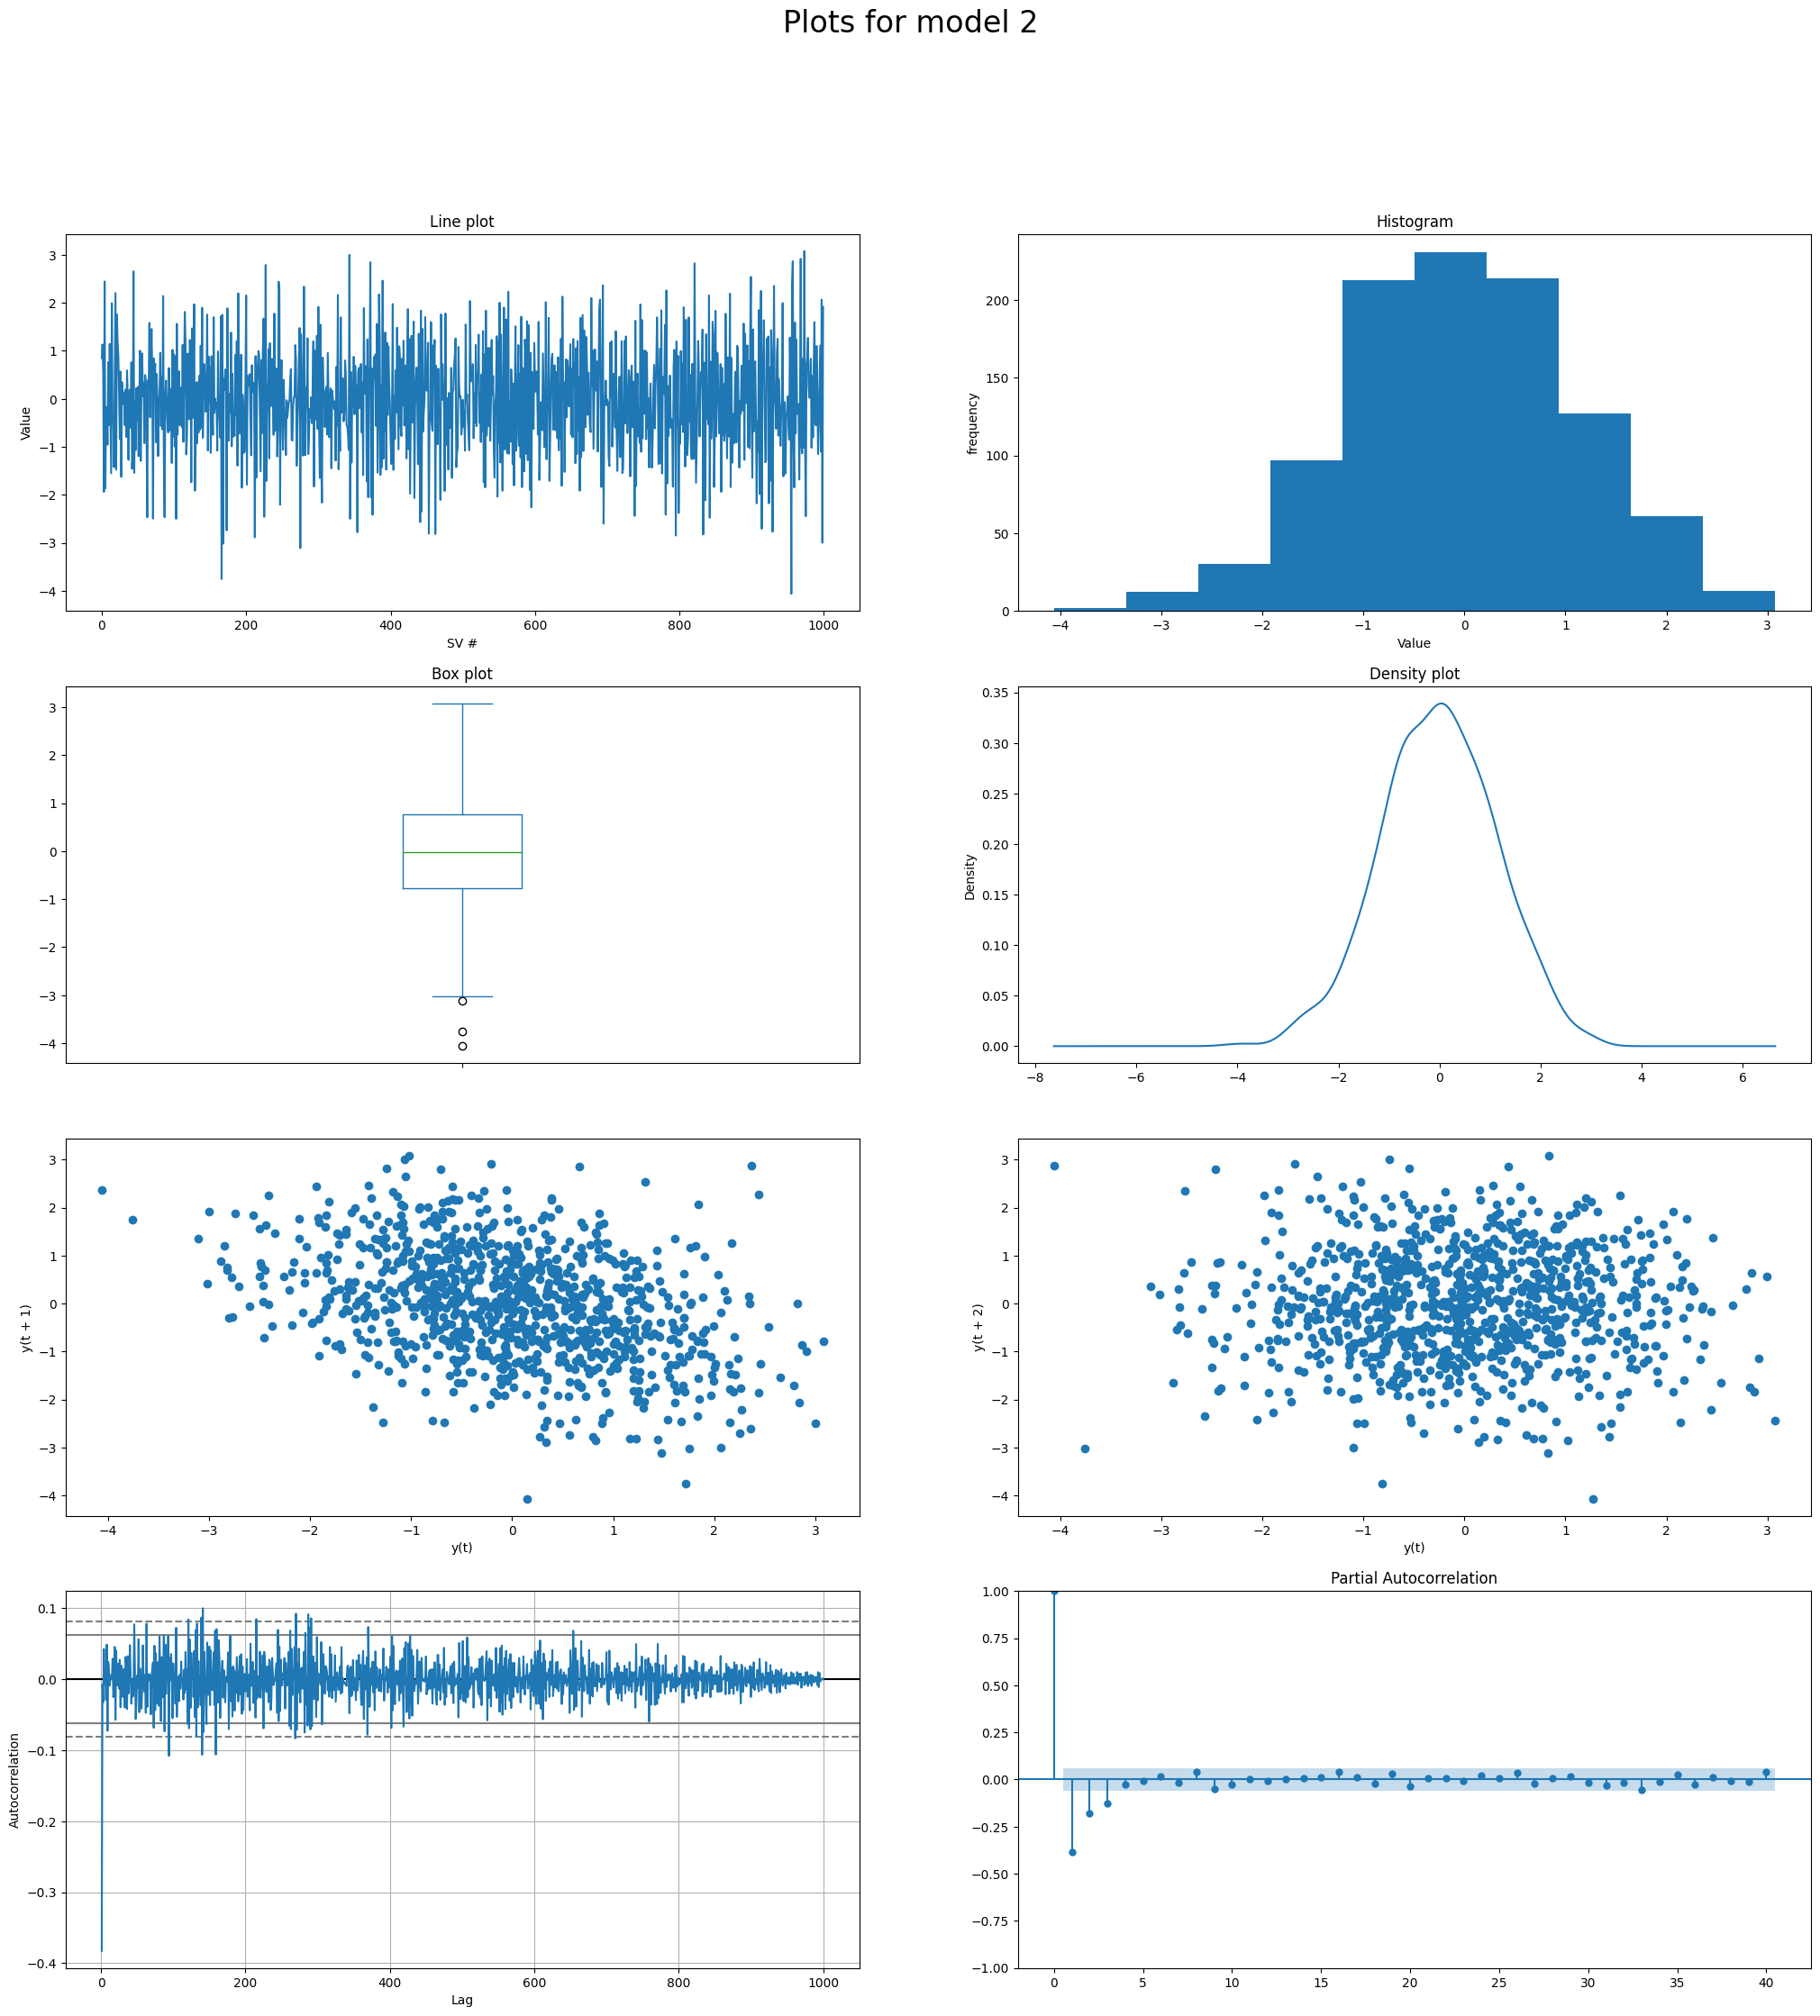

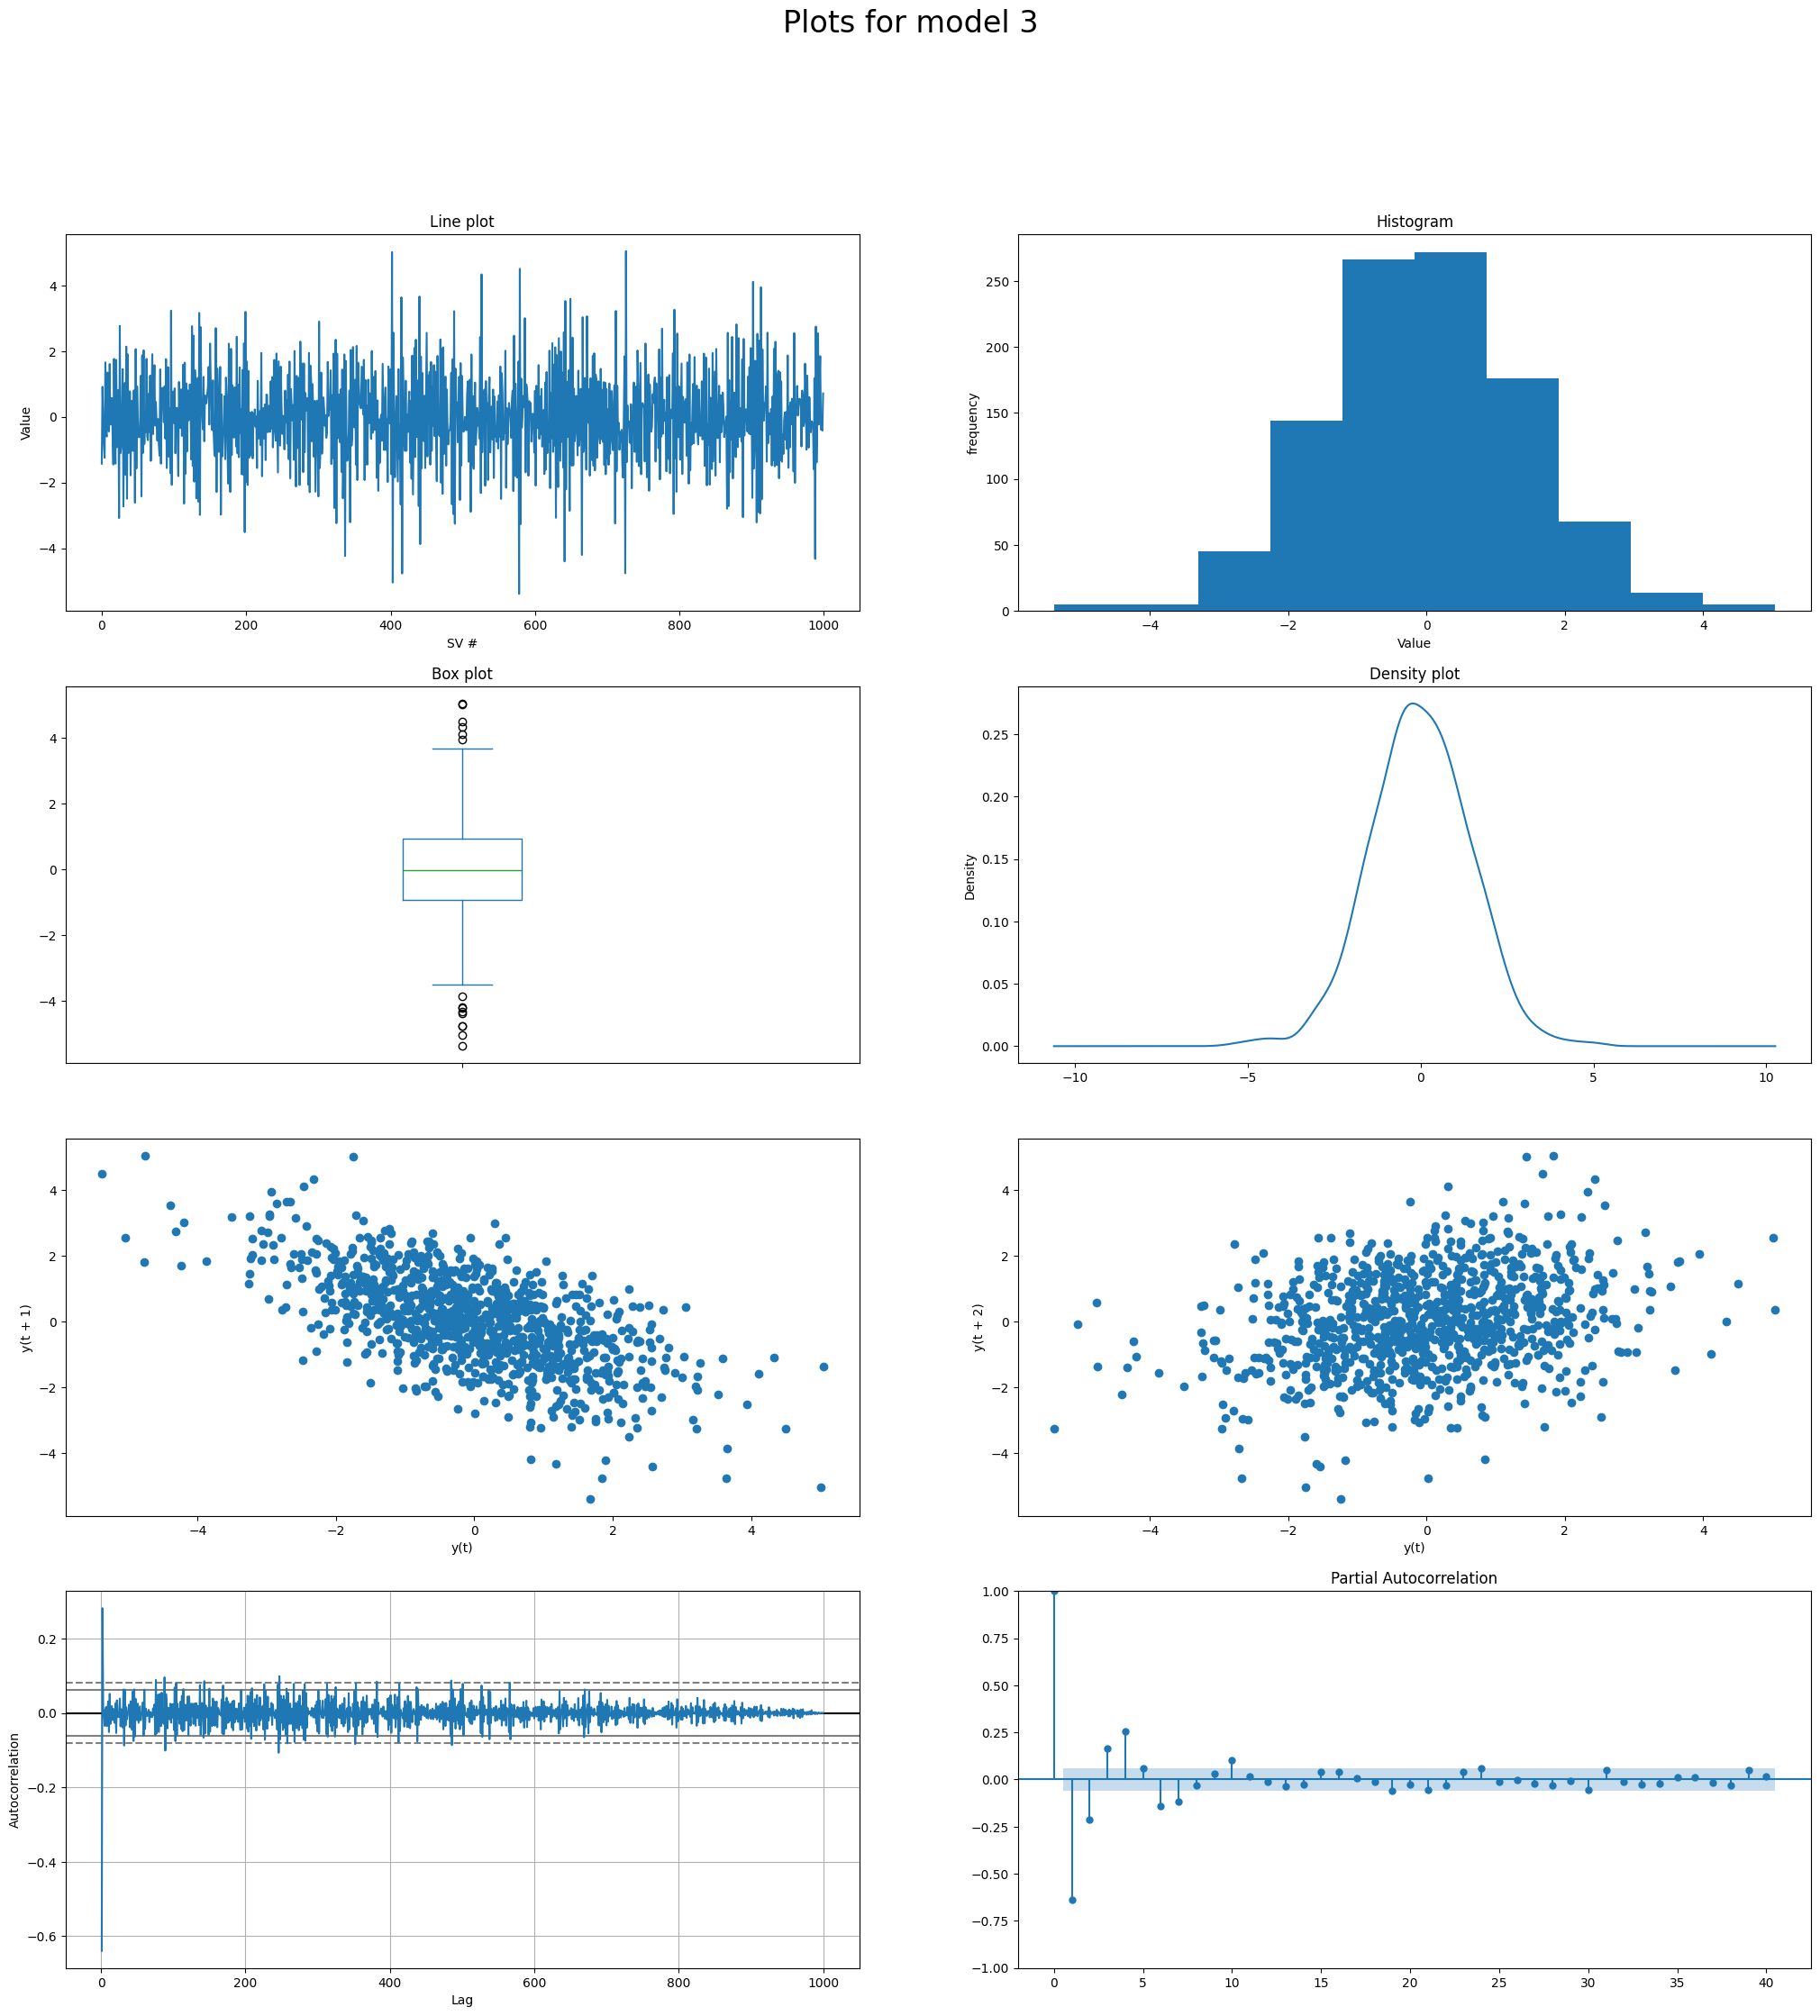

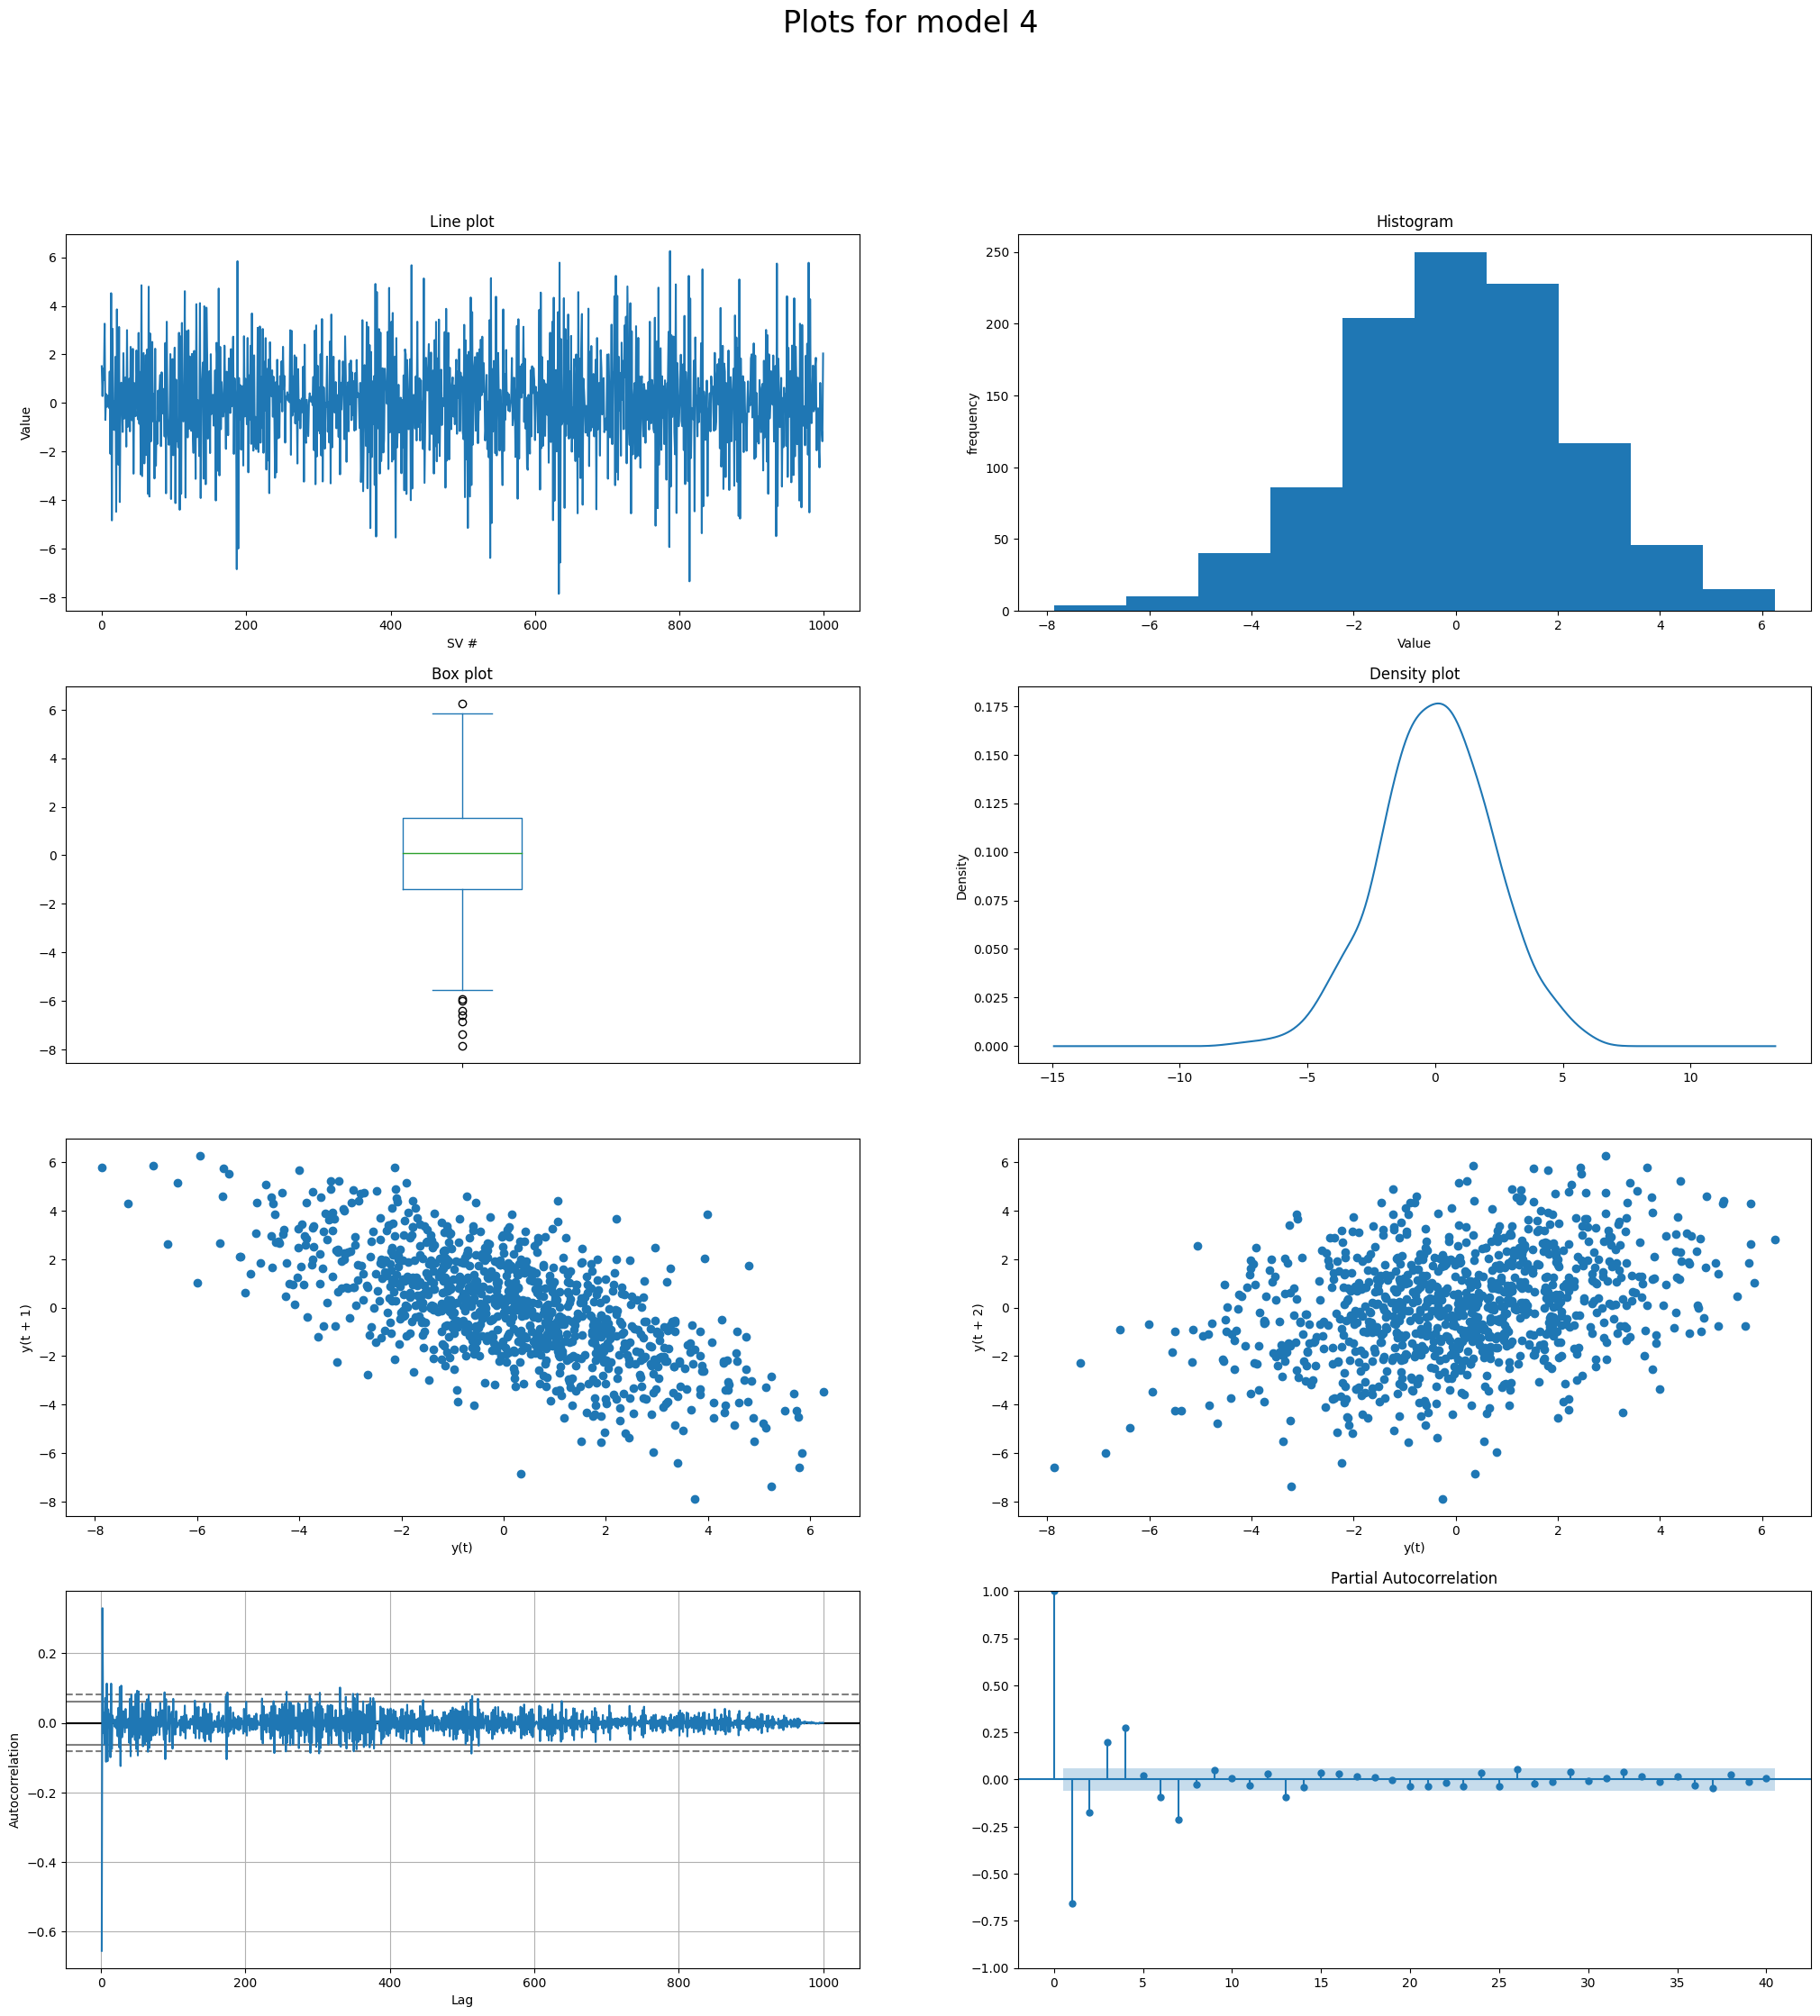

In [19]:
s1, p1 = gen_arma(lagcoeffs_ma=[-2], nsample=1000)
s2, p2 = gen_arma(lagcoeffs_ma=[-0.5], nsample=1000)
s3, p3 = gen_arma(lagcoeffs_ma=[-4/5, 16/25], nsample=1000)
s4, p4 = gen_arma(lagcoeffs_ma=[-5/4, 25/16], nsample=1000)

plot_all(Series(s1), lags=40, title="Plots for model 1");
plot_all(Series(s2), lags=40, title="Plots for model 2");
plot_all(Series(s3), lags=40, title="Plots for model 3");
plot_all(Series(s4), lags=40, title="Plots for model 4");

print("Is process 1 invertible?", p1.isinvertible)
print("Is process 2 invertible?", p2.isinvertible)
print("Is process 3 invertible?", p3.isinvertible)
print("Is process 4 invertible?", p4.isinvertible)

# Task 4 - Stationarity, ACF and PACF of ARMA models

### Judge whether each time series is stationary or not, by visual inspection.
- First time series seems to be stationary, just that there is one small variation in the line plot for the current output. 
- Second time series is clearly stationary. 
- Third time series could be stationary, but there are some patterns that could imply a non-stable mean. 
- Fourth time series is probably not stationary, there is a quite significat pattern where the variance is large then small then large again, despite the mean being stationary.

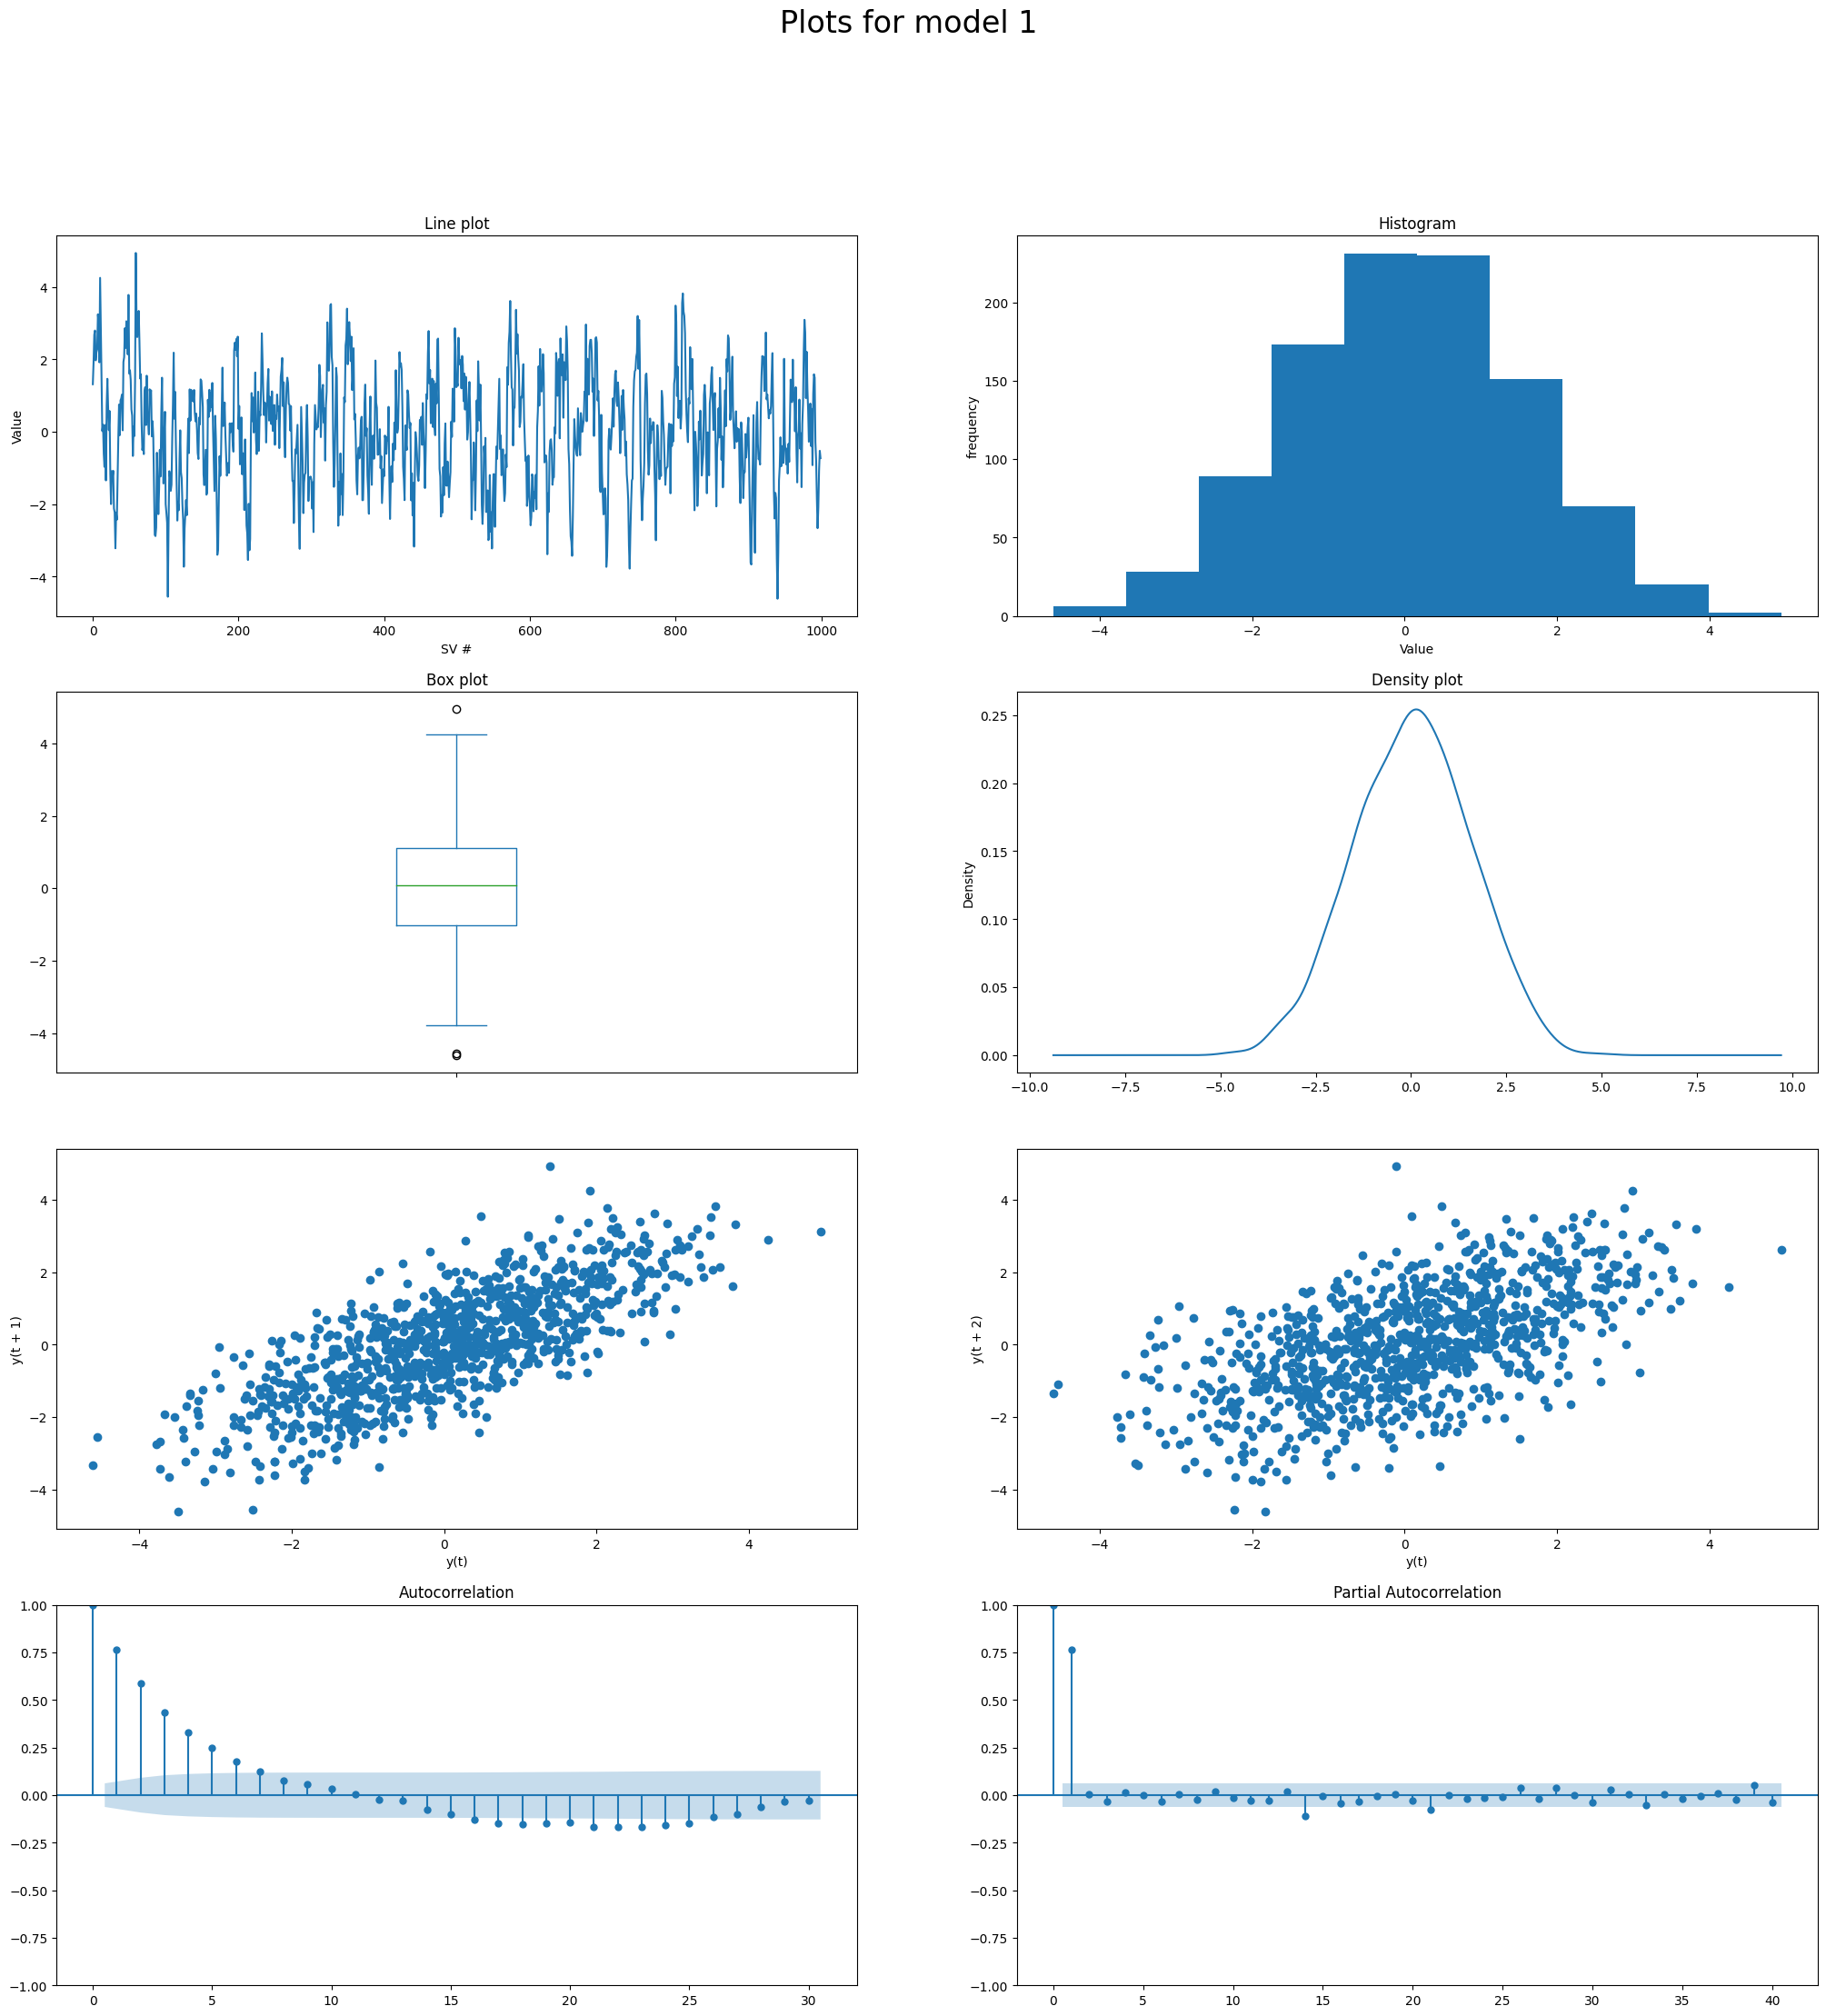

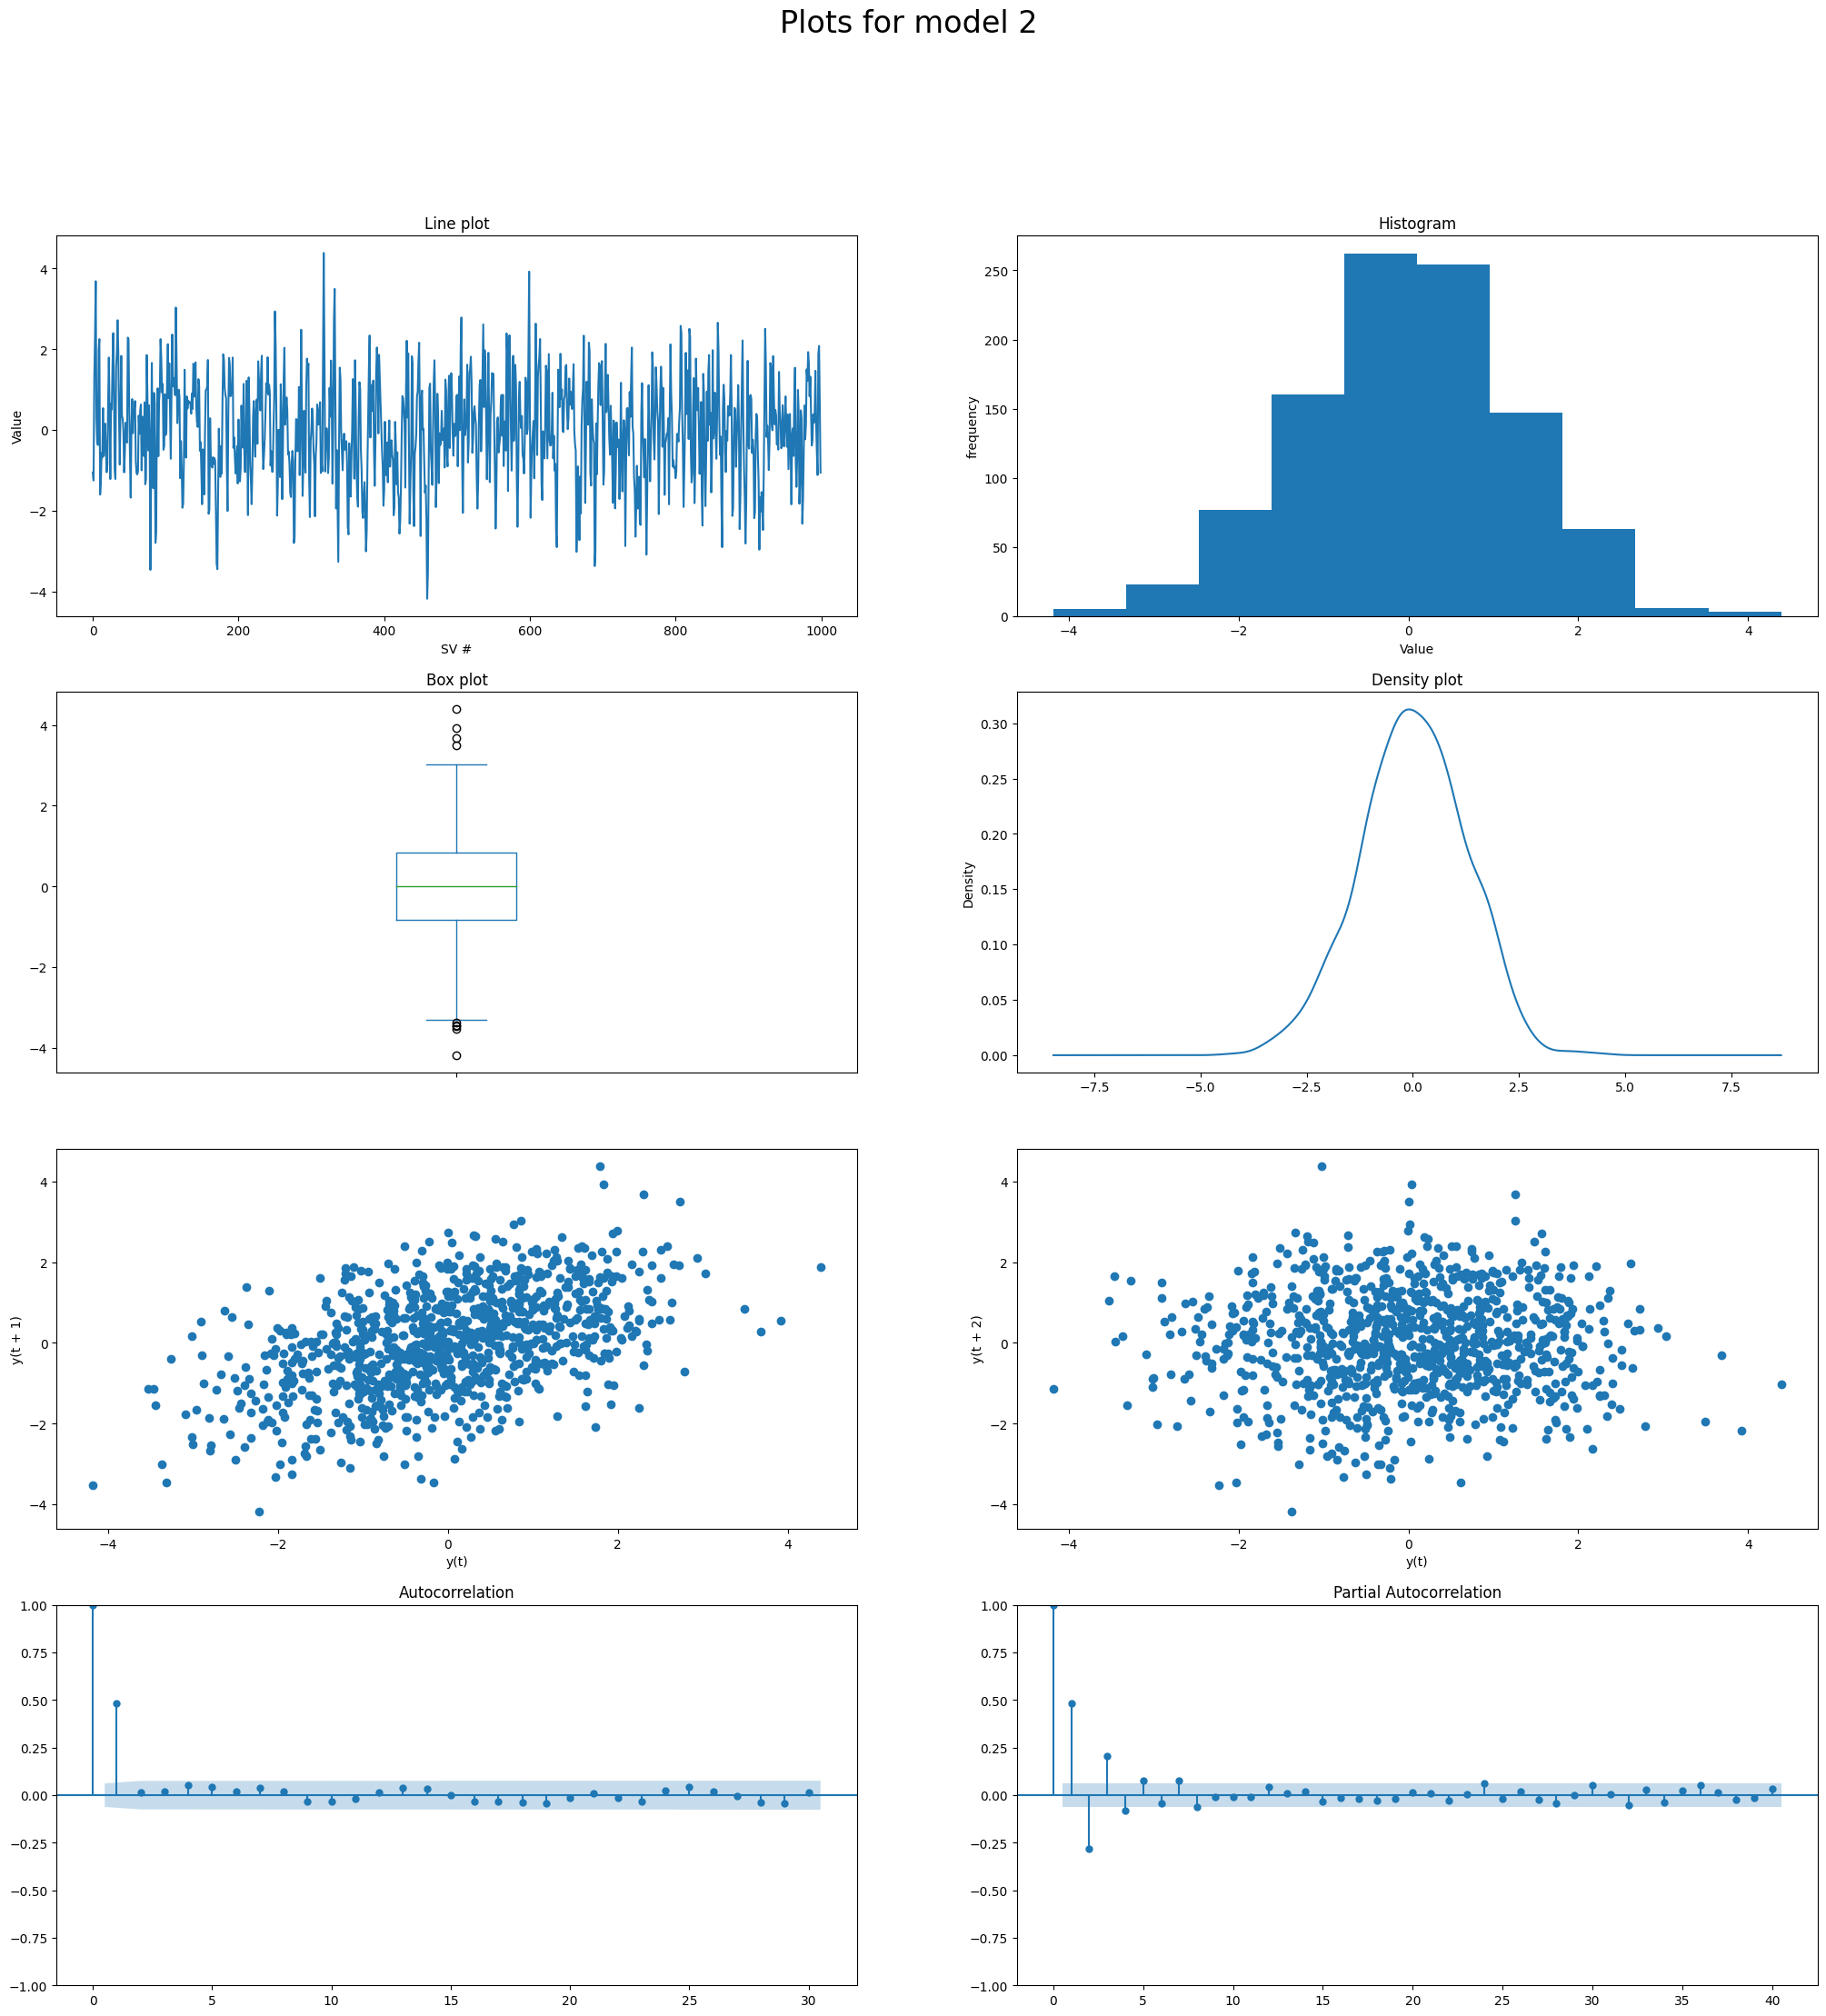

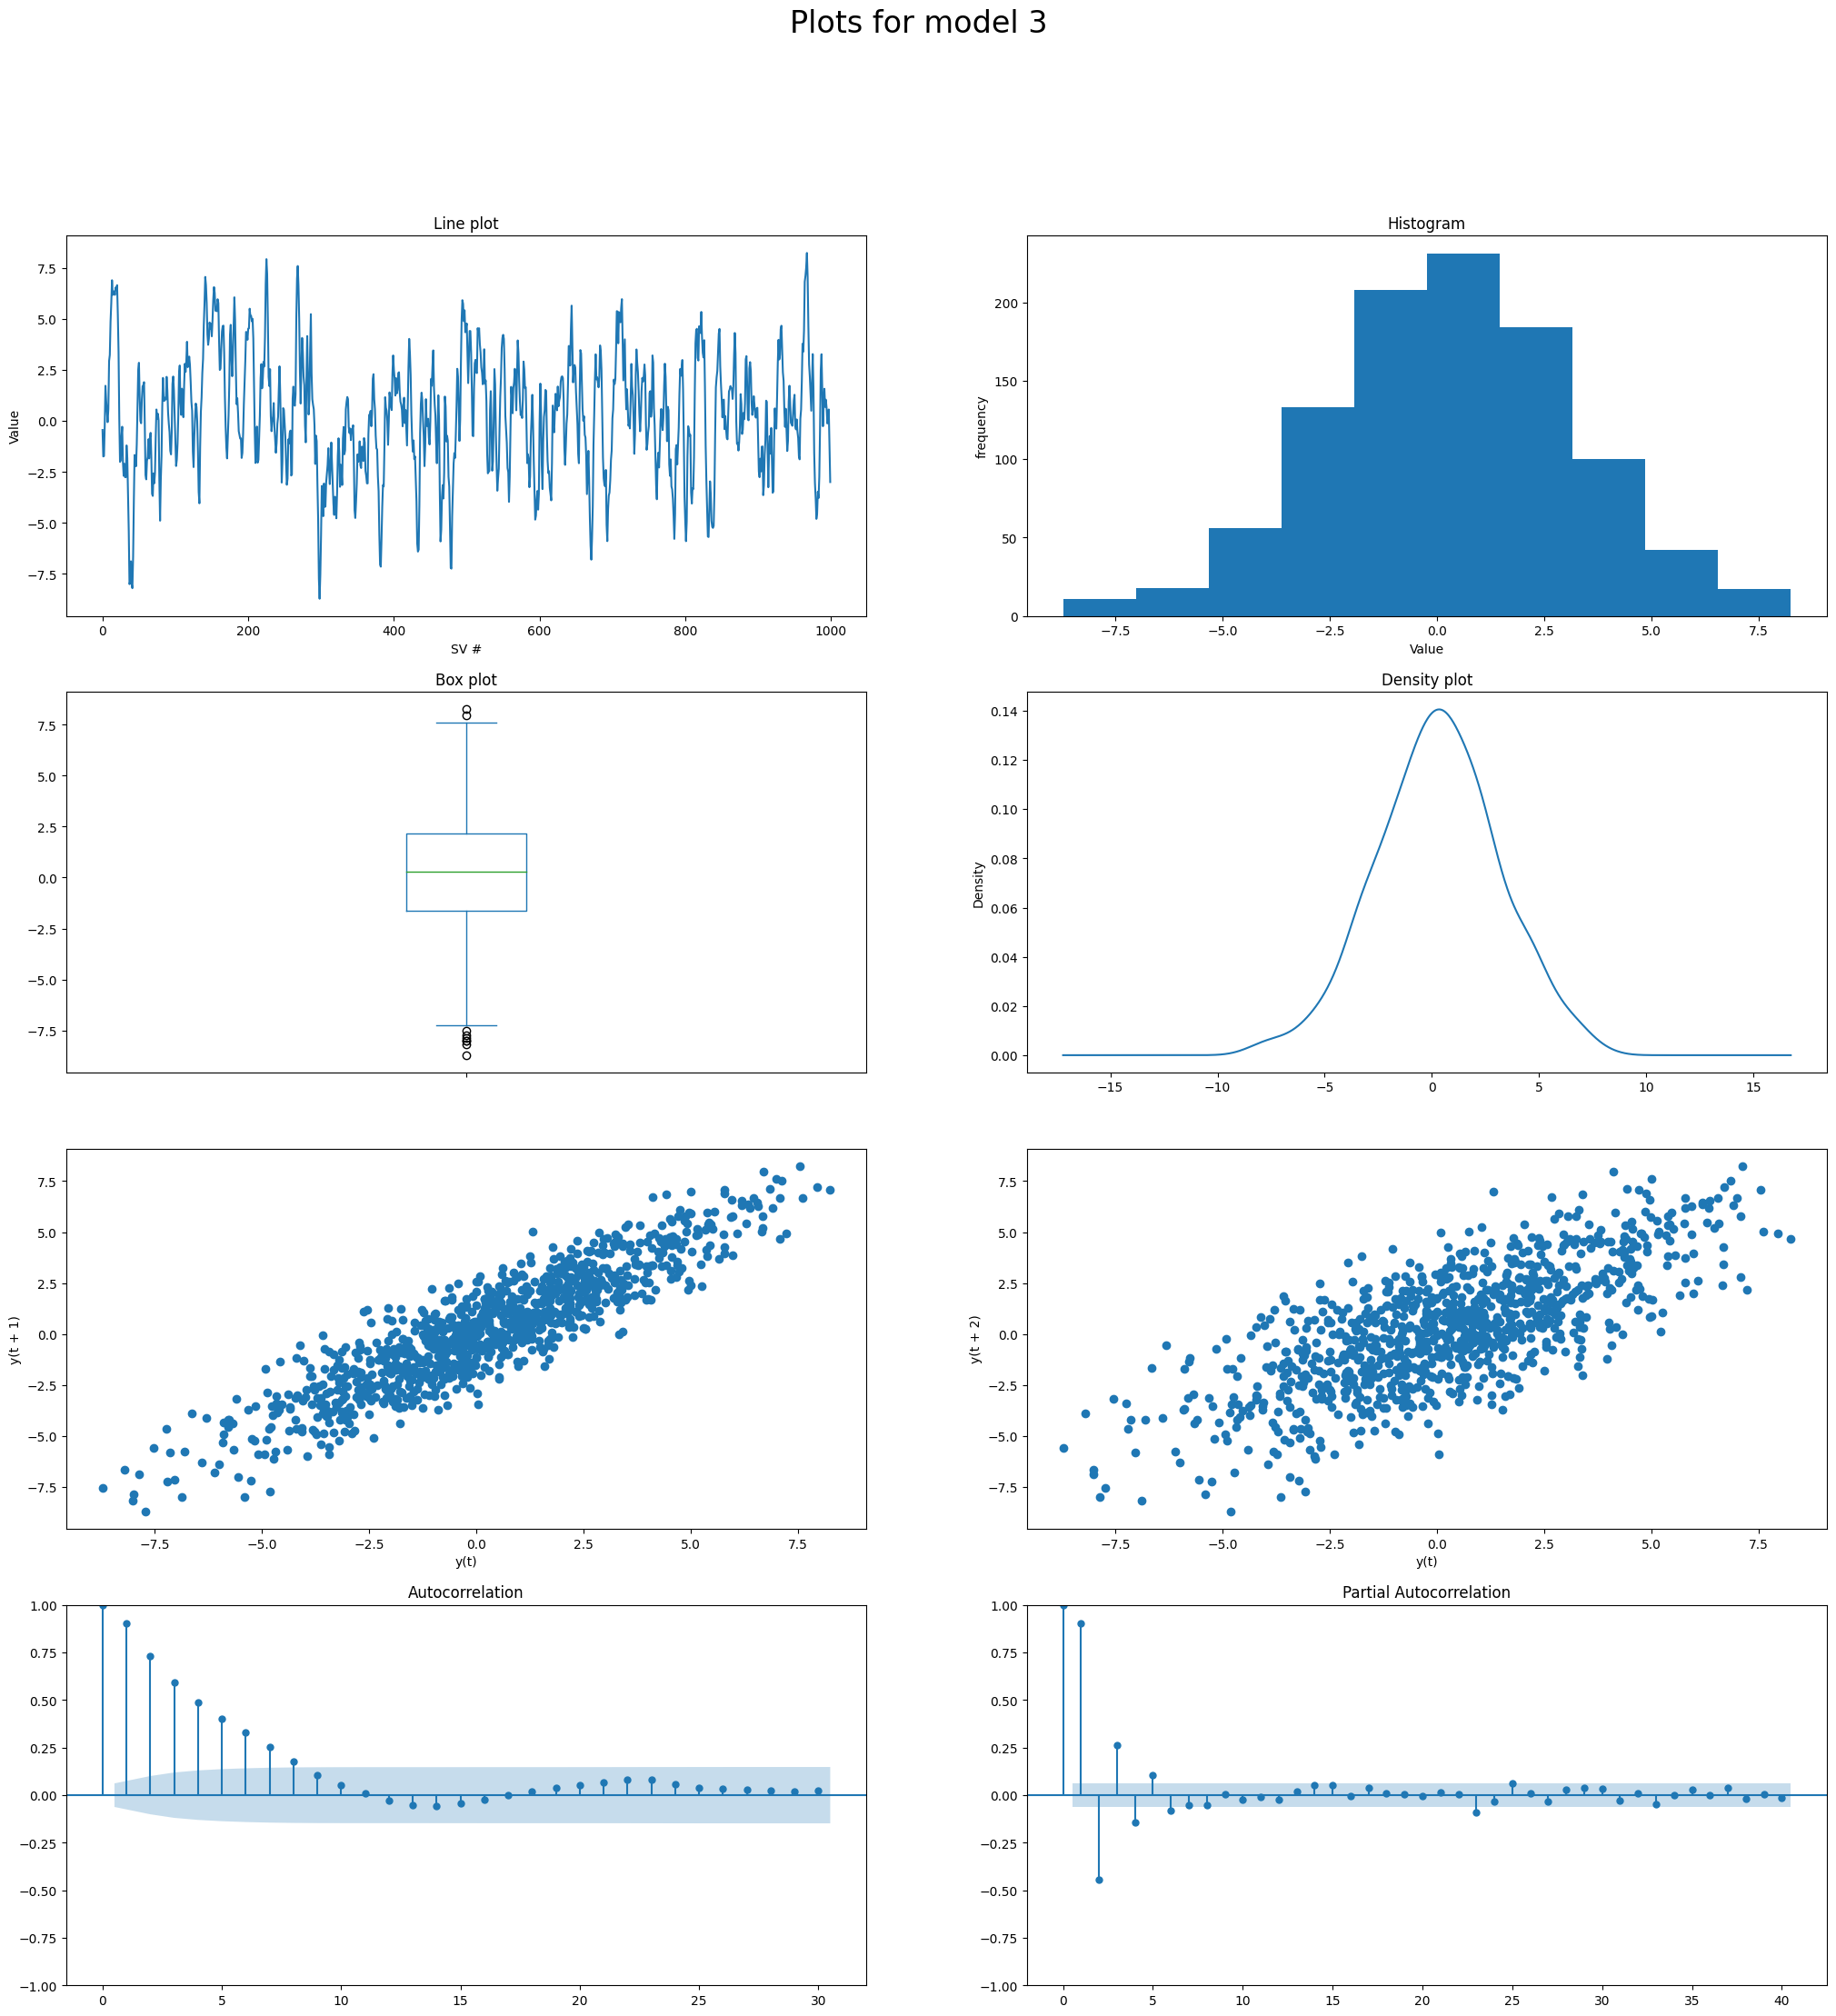

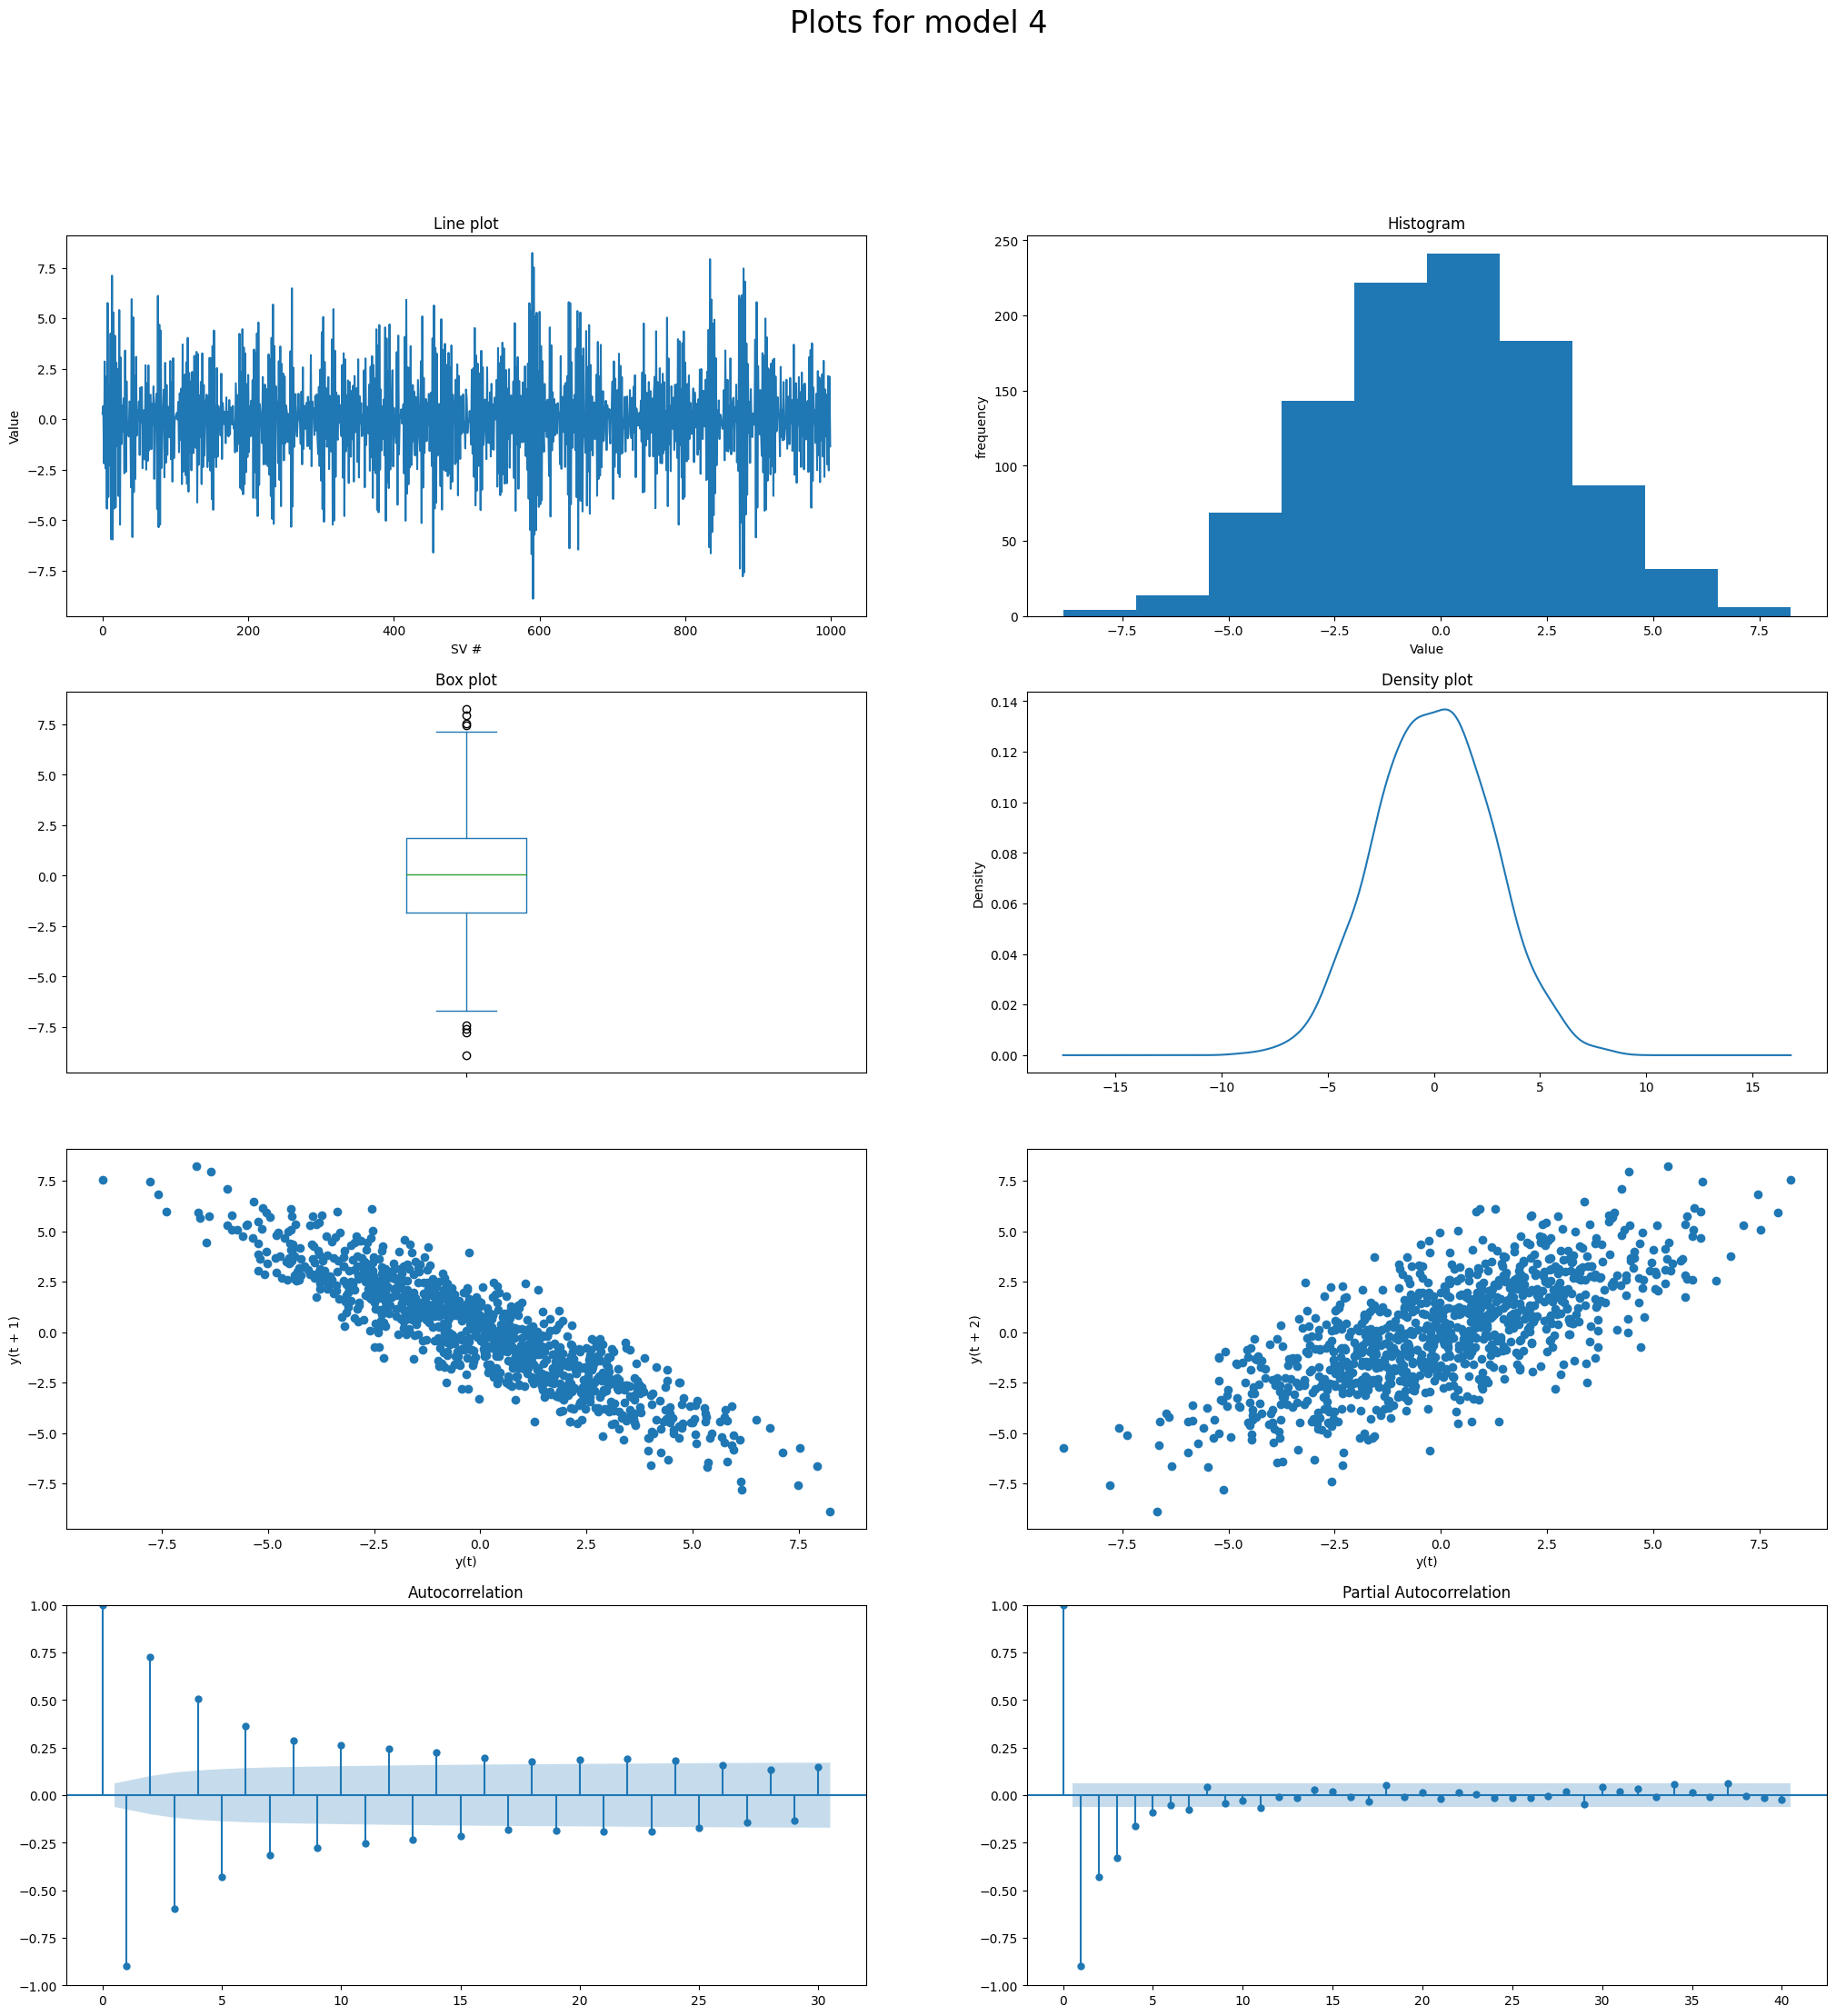

In [88]:
s1, p1 = gen_arma(lagcoeffs_ar=[0.8], nsample=1000)
s2, p2 = gen_arma(lagcoeffs_ma=[0.7], nsample=1000)
s3, p3 = gen_arma(lagcoeffs_ar=[0.8], lagcoeffs_ma=[0.7], nsample=1000)
s4, p5 = gen_arma(lagcoeffs_ar=[-0.8], lagcoeffs_ma=[-0.7], nsample=1000)

plot_all(Series(s1), lags=40, title="Plots for model 1");
plot_all(Series(s2), lags=40, title="Plots for model 2");
plot_all(Series(s3), lags=40, title="Plots for model 3");
plot_all(Series(s4), lags=40, title="Plots for model 4");

### Use the ADF test method to judge whether each time series is stationary or not. Do the results match your visual inspection?

The results from the adf test shows that the visual inspection was correct, and also verified that the uncertainty about model 1 being stationary.

In [21]:
adfuller_test(Series(s1))
adfuller_test(Series(s2))
adfuller_test(Series(s3))
adfuller_test(Series(s4))

ADF Statistic: -10.628651740863843
p-value: 5.284025777002337e-19
Critial Values:
1%, -3.4369127451400474
5%, -2.864437475834273
10%, -2.568312754566378
------------------------------
Critical values less than adf statistic: 0
p-value is less than 5% margin: True
Stationary? True
------------------------------
ADF Statistic: -8.997688523706987
p-value: 6.6261058473216364e-15
Critial Values:
1%, -3.4369658620871286
5%, -2.8644609013346485
10%, -2.56832523159495
------------------------------
Critical values less than adf statistic: 0
p-value is less than 5% margin: True
Stationary? True
------------------------------
ADF Statistic: -7.326028219613067
p-value: 1.1604538050101116e-10
Critial Values:
1%, -3.436972562223603
5%, -2.864463856182476
10%, -2.5683268054280175
------------------------------
Critical values less than adf statistic: 0
p-value is less than 5% margin: True
Stationary? True
------------------------------
ADF Statistic: -14.55795304213824
p-value: 4.846595441317101e-27

### Call the corresponding statsmodels functions to judge if each ARMA process is stationary and invertible.

The stationary property of the processes correspond to the adf test and the visual inspection.

In [22]:
print(f"Is model 1: invertible? {p1.isinvertible} | stationary? {p1.isstationary}")
print(f"Is model 2: invertible? {p2.isinvertible} | stationary? {p2.isstationary}")
print(f"Is model 3: invertible? {p3.isinvertible} | stationary? {p3.isstationary}")
print(f"Is model 4: invertible? {p4.isinvertible} | stationary? {p4.isstationary}")

Is model 1: invertible? True | stationary? True
Is model 2: invertible? True | stationary? True
Is model 3: invertible? True | stationary? True
Is model 4: invertible? False | stationary? True


### Draw histogram, density plot, and box plot for each time series with 1000 data points. Are there any outliers? Why?
There are outliers for all box plots, but they are equally divided between over and under the confidence intervals to it should not affect the stationarity results. These outliers are produced because of the error distribution that can sometimes yield values outside the confidence interval by nature, and since that's not common they become outliers.

### Draw lag-1 and lag-2 plots for each time series. Do you observe any auto-correlation from the lag plots?
The second ARMA model does not show any particular signs of autocorrelation. However, the three other models show clear diagonal patterns. Model 4 might indicate seasonality because lag-1 slopes upwards, and lag-2 downwards, meanwhile model 1 and 3 show an increasing autocorrelation pattern in the data.

### Questions
- What characteristics can you observe from the ACF, PACF graphs of the AR(p) model?
The auto-correlation is high for lags 1 and 2 in the PACF plot, then they are not of any significance. The ACF plot shows decaying auto-correlation until lag 500, after that there is no significant observations.
- What characteristics can you observe from the ACF, PACF graphs of the MA(q) model?
The PACF plot shows great auto-correlation for until around lag 5, then not of significance for higher lags. The ACF is almost never outside the confidence interval, and the few occurences are very close to still being random. 
- What characteristics can you observe from the ACF, PACF graphs of the ARMA(p, q) models?
Both PACF graphs are quite significant until the lag=10 mark. Both ACFs show strong auto-correlation that does not even seem to disappear with larger lag, but with interval based correlation that surpasses the confidence intervals.

# Task 5 - ARIMA modeling and prediction

### Step 1. Randomness test. Check if the sequence is random using line plot, lag-1 plot and Lung-Box test. If it is, you are done, otherwise continue to the next steps.

lb_stat     lb_pvalue
1    65.914271  4.709690e-16
2   114.149261  1.632311e-25
3   151.955524  9.974838e-33
4   189.507131  6.764012e-40
5   220.874422  9.652744e-46
6   253.060924  9.093751e-52
7   276.676346  5.742962e-56
8   301.607312  1.873081e-60
9   324.274857  1.832207e-64
10  350.976775  2.472290e-69

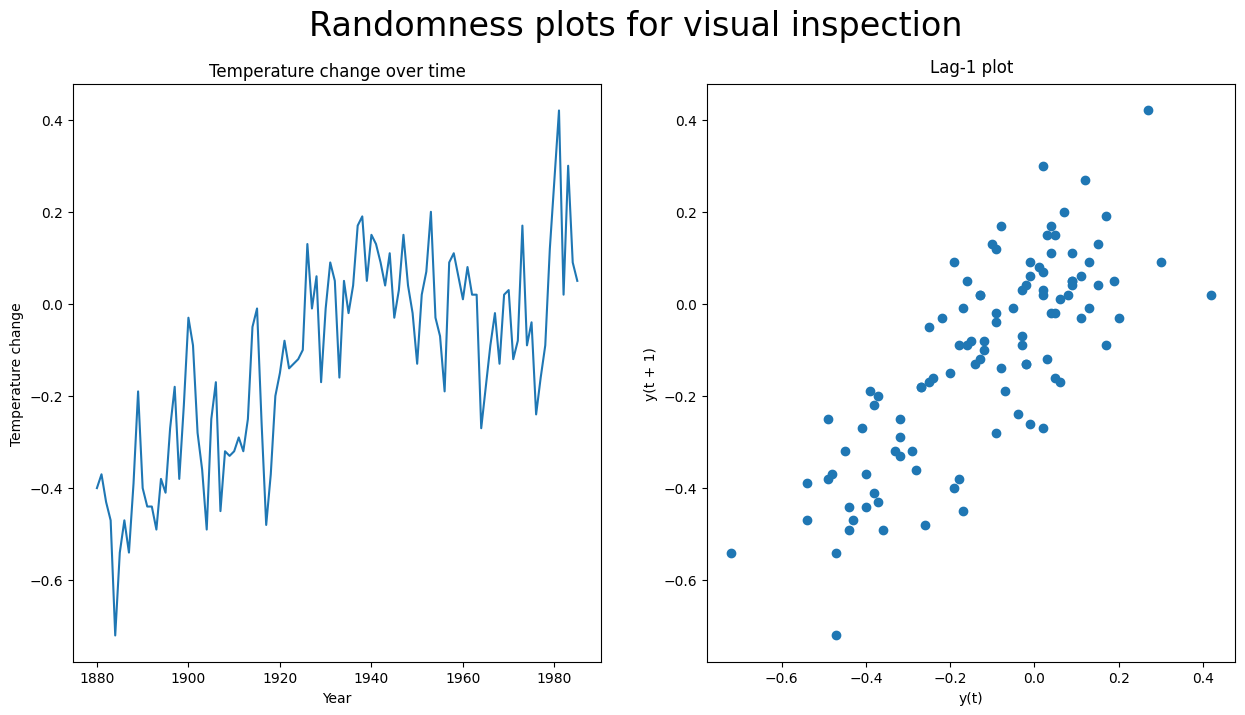

In [58]:
data = read_csv('tempchange.csv')
series = Series(data=data['temperature change'].values, index=data['year'].values)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5), )
fig.subplots_adjust()
fig.suptitle("Randomness plots for visual inspection", fontsize=24)
series.plot(ax=axes[0], kind='line', title='Temperature change over time', xlabel='Year', ylabel='Temperature change')
plotting.lag_plot(series, ax=axes[1], lag=1)
axes[1].text(0.5, 1.02, 'Lag-1 plot', ha='center', fontsize=12, transform=axes[1].transAxes)

# ljungbox test
ljungbox(series)

As can be observed in the above plots, it is obvious that the time series is not random, the line plot surely has an upwards trend and the lag-1 plot has a quite clear upwards trend. Furthermore, the ljung-box test results indicate very small pvalues and implies that the null hypothesis (no auto-correlation) should be rejected, i.e. it can be concluded that there is auto-correlation in the time series.

### Step 2. Stationarity test and differencing. Test the stationarity of the series. If it is not stationary, use the difference operation to generate a differenced sequence. In this step, you determine the value of d. You may need to do second difference for some time series, if necessary.

In [62]:
adfuller_test(series)

ADF Statistic: -1.9091315185935462
p-value: 0.32777762531438015
Critial Values:
1%, -3.4989097606014496
5%, -2.891516256916761
10%, -2.5827604414827157
------------------------------
Critical values less than adf statistic: 3
p-value is below the 5% significance level: False
Stationary? False
------------------------------


Based on the above adfuller test, the series is not stationary by its original representation. It has to be differenced.

In [66]:
firstorderdiff = series.diff()[1:]
adfuller_test(firstorderdiff)

ADF Statistic: -6.437287387132189
p-value: 1.6408522350645357e-08
Critial Values:
1%, -3.4989097606014496
5%, -2.891516256916761
10%, -2.5827604414827157
------------------------------
Critical values less than adf statistic: 0
p-value is below the 5% significance level: True
Stationary? True
------------------------------


As can be seen in the second ad-fuller test, the series is now stationary and we can continue to the next step. Also, it is found that parameter $d=1$

### Step 3. Model identification. Draw ACF and PACF plots of the sequence. Based on the ACF, PACF graphs, you determine the values for p and q.

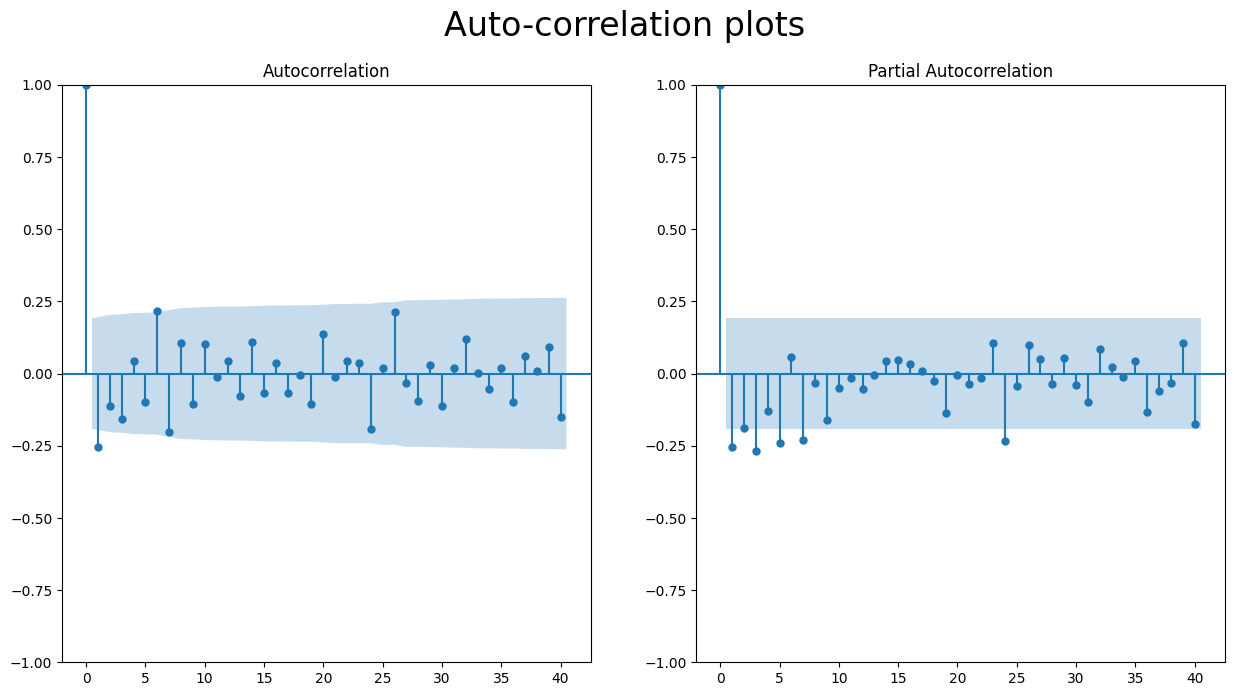

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5), )
fig.subplots_adjust()
fig.suptitle("Auto-correlation plots", fontsize=24)
plot_acf(firstorderdiff, lags=40, ax=axes[0])
plot_pacf(firstorderdiff, lags=40, ax=axes[1], method='ywm');

Based on the ACF graph we can identify the value of $q$ by inspecting when the auto-correlation is close to 0. By this, we can see that the parameter $q = 11$. Likewise we can identify $p = 11$, when the partial auto-correlation is close to 0.

### Step 4. Parameter estimation and model optimization. Since there can be multiple models which give good results, you can choose one optimal one based on, e.g., the AIC criterion.